## Оценка эффективности рекламы Procrastinate Pro+

**Цель анализа:** разобраться с причинами неудовлетворительных финансовых показателей Procrastinate Pro+ и оценить эффективность рекламных компаний.

**Ключевые задачи:** 
* Составить портреты пользователей (местоположение, устройство, платежеспособность)
* Оценить эффективность рекламных компаний (стоимость привлечения, окупаемость)
* Рекомендации по увеличению трафика и окупаемости

Данные для анализа предоставлены в файлах:
1) `visits_info_short.csv` - лог сервера с информацией о посещениях сайта
2) `orders_info_short.csv` - информация о заказах
3) `costs_info_short.csv` - информация о расходах на рекламу

<a name='Описание-данных'>**Описание данных** <br> </a>
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года (01.05.2019-27.10.2019). <br><br>
В файле `visits_info_short.csv` находится информация о посещениях сайта:

    User Id — уникальный идентификатор пользователя,
    Region — страна пользователя,
    Device — тип устройства пользователя,
    Channel — идентификатор источника перехода,
    Session Start — дата и время начала сессии,
    Session End — дата и время окончания сессии
    
В файле `orders_info_short.csv` находится информация о заказах (данные о покупках):

    User Id — уникальный идентификатор пользователя,
    Event Dt — дата и время покупки,
    Revenue — сумма заказа.
    
В файле `costs_info_short.csv` находится информация о расходах на рекламу:

    dt — дата проведения рекламной кампании,
    Channel — идентификатор рекламного источника,
    costs — расходы на эту кампанию.

**Принятые сокращения и термины:**
* CAC (Customer Acquisition Cost) - стоимость привлечения одного пользователя.
* ROI (Return On Investment) - окупаемость инвестиций (в данном проекте на рекламу, тождественно ROMI).
* LTV (Lifetime Value) - общая сумма средств, которую приносит один пользователь.
* Органический пользователь — это пользователь, который попал в приложение через органический канал привлечения, то есть без прямого использования маркетинговых инструментов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from datetime import datetime, timedelta

### Откроем файлы с данными и выведем общую информацию

In [2]:
# адреса локальных файлов
files = ['local1.csv', 'local2.csv', 'local3.csv']

# URLs на файлы
urls = [r'https://code.s3.yandex.net/***.csv', 
        r'https://code.s3.yandex.net/***.csv', 
        r'https://code.s3.yandex.net/***.csv']

try: # по возмажности локальный файл
    visits, orders, marketing = (pd.read_csv(file) for file in files)
except: # иначе URL
    visits, orders, marketing = (pd.read_csv(file) for file in urls)
    
display(visits.head(1), visits.tail(1))
display(orders.head(1), orders.tail(1))
display(marketing.head(1), marketing.tail(1))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


,User Id,Region,Device,Channel,Session Start,Session End
309900,109329042535,Germany,PC,lambdaMediaAds,2019-10-31 14:17:43,2019-10-31 15:17:04


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


,User Id,Event Dt,Revenue
40211,329994900775,2019-10-31 13:29:06,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3


,dt,Channel,costs
1799,2019-10-27,lambdaMediaAds,12.0


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


В visits надо:
* переименовать столбцы (нижний регистр и "_" взамен " ")
* преобразовать *Session Start* и *Session End* в формат datatime
* добавить столбец со временем сессии в сек, годом(для проверки корректности), месяцем, неделей и датой сессий
* проверить категориальные значения *Region, Device, Channel*

In [4]:
display(orders.info())
display(orders.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


В orders надо:
* переименовать столбцы (нижний регистр и "_" взамен " ")
* преобразовать *Event Dt* в формат datatime
* добавить столбец с месяцем, неделей и датой покупки
* проверить количественное значения *Revenue* (определить почему встречаются значения больше 4,99) 

In [5]:
display(marketing.info())
display(marketing.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


В marketing надо:
* переименовать столбцы (нижний регистр)
* преобразовать *dt* в формат datatime
* проверить категориальное значения *Channel* 
* проверить количественное значения *costs* (определить почему встречаются значения маленькие значения (0,8) и большие 630) 

### Предобработка данных

В visits надо:
* переименовать столбцы (нижний регистр и "_" взамен " ")
* преобразовать *Session Start* и *Session End* в формат datatime
* добавить столбец со временем сессии в сек, годом(для проверки корректности), месяцем, неделей и датой сессий
* проверить категориальные значения *Region, Device, Channel*

<br>В orders надо: 
* переименовать столбцы (нижний регистр и "_" взамен " ")
* преобразовать *Event Dt* в формат datatime
* добавить столбец с месяцем, неделей и датой покупки
* проверить количественное значения *Revenue* (определить почему встречаются значения больше 4,99) 

<br>В marketing надо:
* переименовать столбцы (нижний регистр)
* преобразовать *dt* в формат datatime
* проверить категориальное значения *Channel* 
* проверить количественное значения *costs* (определить почему встречаются значения маленькие значения (0,8) и большие 630) 
<br><br>
Общее:
* Проверить дубликаты
* Пропусков не обнаружено 

#### Приведение названия столбцов к единому формату

In [6]:
# Переименовываем столбцы
visits = visits.rename(columns={'User Id': 'user_id',
                       'Region': 'region',
                       'Device': 'device',
                       'Channel': 'channel',
                       'Session Start': 'session_start',
                       'Session End': 'session_end'})

orders = orders.rename(columns={'User Id': 'user_id',
                                'Event Dt': 'event_dt',
                                'Revenue': 'revenue'})

marketing = marketing.rename(columns={'dt': 'dt',
                                      'Channel': 'channel',
                                      'costs': 'costs'}) 

#### Изменение типа данных

In [7]:
# Приводим данные с датой к формату datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
marketing['dt'] = pd.to_datetime(marketing['dt'])

# Проверяем корректность изменений
for n in [visits['session_start'], visits['session_end'], 
          orders['event_dt'], marketing['dt']]:
    if not pd.api.types.is_datetime64_any_dtype(n):
        print(False) # если другой формат, то выдаст False

#### Проверка значений

##### Категориальные значения в visits

In [8]:
# Проверка региона пользователя
visits.region.unique().tolist()

['United States', 'UK', 'France', 'Germany']

In [9]:
# Проверка устройства пользователя
visits.device.unique().tolist()

['iPhone', 'Mac', 'Android', 'PC']

In [10]:
# Проверка канала перехода пользователя
visits.channel.unique().tolist()

['organic',
 'TipTop',
 'RocketSuperAds',
 'YRabbit',
 'FaceBoom',
 'MediaTornado',
 'AdNonSense',
 'LeapBob',
 'WahooNetBanner',
 'OppleCreativeMedia',
 'lambdaMediaAds']

Неявных повторов нет, все значения релевантные

##### Количественных значения в orders

In [11]:
orders.revenue.unique().tolist() # смотрим какие значения встречаются

[4.99, 5.99, 9.99, 49.99, 19.99]

In [12]:
# Значений не много, выведем в табличном виде частоту появления
orders.revenue.value_counts()

revenue
4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
Name: count, dtype: int64

Все значения не разовые. Скорей всего есть разные тарифы, скидки, период оплаты. Значения похожи на релевантные, дополнительно можно уточнить у Заказчика.

##### Категориальные значения в marketing

In [13]:
# Проверка индификатора рекламного источника 
marketing.channel.unique().tolist()

['FaceBoom',
 'MediaTornado',
 'RocketSuperAds',
 'TipTop',
 'YRabbit',
 'AdNonSense',
 'LeapBob',
 'OppleCreativeMedia',
 'WahooNetBanner',
 'lambdaMediaAds']

In [14]:
# Проверим совпадение списков каналов переходов пользователей и рекламных источников
# исключая organic
sorted(visits[visits['channel']!='organic'].channel.unique().tolist()
      ) == sorted(marketing.channel.unique().tolist()
                 )

True

Списки каналов перехода пользователя и рекламных источников совпадают. Значит значения корректны.

##### Количественных значения в marketing

Так как в столбце costs указаны денежные средства, то можно округлить до двух знаков после запятой (исключить ошибки, связанные с преобразованием float)

In [15]:
marketing.costs = marketing.costs.round(2) # выполняем явное преобразование

In [16]:
marketing[marketing['costs']<2].costs.value_counts() # распределение низких бюджетов

costs
1.92    3
1.80    2
1.26    2
1.98    2
1.62    2
1.44    1
0.80    1
1.60    1
Name: count, dtype: int64

In [17]:
marketing[marketing['costs']>300].costs.value_counts() # распределение высоких бюджетов

costs
351.0    4
399.0    4
308.0    3
321.0    3
472.5    3
        ..
332.8    1
311.5    1
476.0    1
343.0    1
588.0    1
Name: count, Length: 75, dtype: int64

In [18]:
# узнаем на кого приходятся низкие бюджеты
marketing[marketing['costs']<2].channel.value_counts()

channel
YRabbit           9
MediaTornado      3
lambdaMediaAds    2
Name: count, dtype: int64

In [19]:
# узнаем на кого приходятся крупные бюджеты
marketing[marketing['costs']>300].channel.value_counts()

channel
TipTop    105
Name: count, dtype: int64

Стоимость рекламного бюджета в день на конкретный канал может быть любая. <br>
Низкие бюджеты приходятся на разные каналы. Анализ будет выполнен позже. <br>
Высокие бюджеты приходятся только на TipTop. Анализ будет выполнен позже.

#### Добавление необходимых столбцов

In [20]:
# создаем столбцы с годом, месяцем, неделей и датой
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.isocalendar().week
visits['session_date'] = visits['session_start'].dt.date

orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.isocalendar().week
orders['event_date'] = orders['event_dt'].dt.date

# создаем столбец с продолжительностью сессии
visits['dur_session_sec'] = (visits['session_end']-visits['session_start']).dt.seconds

In [21]:
visits.sample(2)

,user_id,region,device,channel,session_start,session_end,session_year,session_month,session_week,session_date,dur_session_sec
239492,577601383847,France,Android,organic,2019-07-04 20:19:15,2019-07-04 20:29:17,2019,7,27,2019-07-04,602
255927,556288457890,UK,iPhone,organic,2019-08-05 18:48:21,2019-08-05 19:34:44,2019,8,32,2019-08-05,2783


In [22]:
orders.sample(2)

,user_id,event_dt,revenue,event_month,event_week,event_date
15861,592080241715,2019-09-03 07:56:09,4.99,9,36,2019-09-03
25356,558073324483,2019-10-19 14:02:04,5.99,10,42,2019-10-19


Остальные столбцы будут добавлятся по мере необходимости при анализе.

#### Проверка дубликатов

In [23]:
# поверка дубликатов в visits
visits[visits[['user_id', 'region', 'device', 'session_date']].duplicated()]

,user_id,region,device,channel,session_start,session_end,session_year,session_month,session_week,session_date,dur_session_sec


In [24]:
# поверка дубликатов в orders
orders[orders[['user_id', 'event_date']].duplicated(keep=False)]

,user_id,event_dt,revenue,event_month,event_week,event_date
20067,658065077014,2019-09-26 00:00:05,4.99,9,39,2019-09-26
20256,658065077014,2019-09-26 12:16:54,4.99,9,39,2019-09-26
25617,786994605844,2019-10-21 00:00:13,4.99,10,43,2019-10-21
25840,786994605844,2019-10-21 01:22:06,4.99,10,43,2019-10-21


In [25]:
orders[orders['user_id']==658065077014] # проверим как платил первый пользователь

,user_id,event_dt,revenue,event_month,event_week,event_date
15459,658065077014,2019-08-31 13:54:34,4.99,8,35,2019-08-31
15627,658065077014,2019-09-01 19:03:11,4.99,9,35,2019-09-01
16548,658065077014,2019-09-06 23:25:50,4.99,9,36,2019-09-06
16717,658065077014,2019-09-07 06:14:24,4.99,9,36,2019-09-07
20067,658065077014,2019-09-26 00:00:05,4.99,9,39,2019-09-26
20256,658065077014,2019-09-26 12:16:54,4.99,9,39,2019-09-26
22474,658065077014,2019-10-06 17:52:02,4.99,10,40,2019-10-06
24811,658065077014,2019-10-17 14:36:08,4.99,10,42,2019-10-17


<a name='график-платежей'>Видим что пользователь совершал по 2 покупки каждую недели, кроме последних двух покупок.<br> </a>
Если оплачивается какая либо разовая доп услуга, то, скорей всего, дубликатов по дням было больше чем 2. <br>
Если покупается подписка, то возможно есть возможность оплачивать другой аккаунт. <br>
Возможно имело место ошибка в оплате (двойная оплата) и денежные средства в итоге были вернуты пользователю. <br>
Надо уточнить у Заказчика, что можно купить в приложении и какой регламент работы (в части данных) с возратом денежных средств. <br>
Т.к. дубликатов оплаты по дням всего два и они не окажут существенного влияния на данные, то оставим их до уточнения деталей.

In [26]:
# проверка дубликатов в marketing
marketing[marketing[['dt', 'channel']].duplicated()]

,dt,channel,costs


### Инициализируем необходимые функции

##### get_profiles

In [27]:
# функция создания профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    try:
        profiles['dt'] = profiles['first_ts'].dt.floor('d')
        profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()
        # если нужно получить только № месяца без привязки к году
        # profiles['month'] = profiles['first_ts'].dt.month 
    except TypeError: # ДЛЯ СТАРЫХ ВЕРСИЙ Python/pandas
        profiles['dt'] = profiles['first_ts'].dt.date 
        profiles['month'] = profiles['first_ts'].astype('datetime64[M]') 
        
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
           
    return profiles  # возвращаем профили с CAC

##### get_retention

In [28]:
# функция для расчета Retantion Rate (RR, удержание)
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа 
    # тех, которые присоединились позже, чем observation_date - horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим «треугольную таблицу» 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к «треугольной» таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждую «ячейку» на соответствующий размер когорты и получаем retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # исключаем все лайфтаймы, превышающие горизонт анализа
        result['cohort_size'] = cohort_sizes                                                                     # восстанавливаем размеры когорт
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped, result_in_time

##### get_conversion

In [29]:
# функция для расчета Conversion Rate (CR)
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
						):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time
    

##### get_ltv

In [30]:
# функция для расчета время жизни (LTV)
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
						):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

##### filter_data

In [31]:
# функция для использования фультрации (скользящего среднего)
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

##### plot_retention

In [32]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

##### plot_conversion

In [33]:
# функция для построения графиков конверсии (CR)
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

##### plot_ltv_roi

In [34]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7, legends_second_vis=True):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    if not legends_second_vis: # отключаем повторные легенды в случае флага
        plt.legend().set_visible(False)
    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    if not legends_second_vis: # отключаем повторные легенды в случае флага
        plt.legend().set_visible(False)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    if not legends_second_vis: # отключаем повторные легенды в случае флага
        plt.legend().set_visible(False)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

##### prof_table_crit

In [35]:
# функция для формирования таблицы распределения платящих пользователей по критерию
def prof_table_crit(df_profiles, criterion):
    df_created = df_profiles.groupby(criterion).agg({'user_id':'count',
                                'payer':'mean'
                        }).sort_values(by='payer', ascending=False
                        ).reset_index()
    
    # Добавляем шаг уменьшения для % платящих
    df_created['delta_payer'] = (df_created.payer.diff(periods=1)*-100).round(2)
    # Добавляем % от общего числа пользователей
    df_created['users, %'] = (df_created.user_id / df_created.user_id.sum() *100
                           ).round(2)
    
    # настраиваем формат отображения
    df_created['payer'] = (df_created.payer*100).round(2)
    df_created = df_created.rename(columns={'user_id':'count_user',
                                         'payer':'payer, %'})
    
    return df_created

### Исследовательский анализ данных

#### Составление профиля пользователей

Создаем таблицу с пользователями используя [функцию get_profiles](#Инициализируем-необходимые-функции)

In [36]:
profiles = get_profiles(visits, orders, None, marketing, event_names=[])

# допольнительно добавим общую сумму, которую заплатил каждый конкретный пользователь
profiles = profiles.merge(orders.groupby('user_id'
                ).agg({'revenue':'sum'}), on='user_id', how='left')

profiles.revenue = profiles.revenue.fillna(0) # заменяем NaN на 0 (для неплатящих)

profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,revenue
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,14.97
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,0.00
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,0.00
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,0.00


In [37]:
print('Минимальная дата привлечения:', profiles.dt.min().strftime('%Y-%m-%d'))
print('Максимальная дата привлечения:', profiles.dt.max().strftime('%Y-%m-%d'))

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


In [38]:
profiles.shape[0] # выведем количество уникальных пользователей

150008

In [39]:
# % платящих пользователей (без разбивки)
print(f'% платящих пользователей: {(profiles.payer.mean()*100):.2f} %') 

% платящих пользователей: 5.92 %


#### Анализ по географии пользователей

Создаем таблицу с геграфией пользователей используя [функцию prof_table_crit](#Инициализируем-необходимые-функции)

In [40]:
# таблица с географией пользователей
profiles_geo = prof_table_crit(profiles, 'region')
profiles_geo

,region,count_user,"payer, %",delta_payer,"users, %"
0,United States,100002,6.90,NaN,66.66
1,Germany,14981,4.11,2.79,9.99
2,UK,17575,3.98,0.13,11.72
3,France,17450,3.80,0.18,11.63


**Промежуточный вывод по географии пользователей**: <br>
- Пользователи из четырех стран
- Больше всего пользователей из США (66,66 % от всех пользователей)
- Самые платящие пользователи в США (6,9 %)
- Самые не платящие пользователи во Франции (3,8 %)
- В США доля платящих пользователей значительно выше, чем в других странах

#### Анализ по устройствам пользователей

Создаем таблицу по устройствам пользователей используя [функцию prof_table_crit](#Инициализируем-необходимые-функции)

In [41]:
# таблица по устройствам пользователей
profiles_device = prof_table_crit(profiles, 'device')
profiles_device

,device,count_user,"payer, %",delta_payer,"users, %"
0,Mac,30042,6.36,NaN,20.03
1,iPhone,54479,6.21,0.16,36.32
2,Android,35032,5.85,0.36,23.35
3,PC,30455,5.05,0.81,20.30


**Промежуточный вывод по устройствам пользователей**: <br>
- Больше всего пользователей пользуются iPhone (36,32 % от всех пользователей)
- Самые платящие пользователи пользуются Mac (6,36 %), на втором месте iPhone(6,21 %)
- Самые не платящие пользователи пользуются PC (5,05 %)
- В распределении по количеству пользователей выделяются пользователи iPhone, по остальным устройствам распределение равномерно

#### Анализ по рекламным источникам


Создаем таблицу по рекламным источникам используя [функцию prof_table_crit](#Инициализируем-необходимые-функции)

In [42]:
# таблица по рекламным источникам
profiles_channel = prof_table_crit(profiles, 'channel')
profiles_channel

,channel,count_user,"payer, %",delta_payer,"users, %"
0,FaceBoom,29144,12.20,NaN,19.43
1,AdNonSense,3880,11.34,0.86,2.59
2,lambdaMediaAds,2149,10.47,0.87,1.43
3,TipTop,19561,9.60,0.87,13.04
4,RocketSuperAds,4448,7.91,1.69,2.97
5,WahooNetBanner,8553,5.30,2.62,5.70
6,YRabbit,4312,3.83,1.47,2.87
7,MediaTornado,4364,3.57,0.25,2.91
8,LeapBob,8553,3.06,0.51,5.70
9,OppleCreativeMedia,8605,2.71,0.36,5.74


In [43]:
# выведем отсортированные по количеству пользователей
profiles_channel.sort_values(by='users, %', ascending=False)

,channel,count_user,"payer, %",delta_payer,"users, %"
10,organic,56439,2.06,0.65,37.62
0,FaceBoom,29144,12.20,NaN,19.43
3,TipTop,19561,9.60,0.87,13.04
9,OppleCreativeMedia,8605,2.71,0.36,5.74
5,WahooNetBanner,8553,5.30,2.62,5.70
8,LeapBob,8553,3.06,0.51,5.70
4,RocketSuperAds,4448,7.91,1.69,2.97
7,MediaTornado,4364,3.57,0.25,2.91
6,YRabbit,4312,3.83,1.47,2.87
1,AdNonSense,3880,11.34,0.86,2.59


**Промежуточный вывод по рекламным источникам**: <br>
- Больше всего пользователей пришло самостоятельно (37,62 % от всех пользователей). На втором месте по рекламе FaceBoom (19,43 %), на третьем TipTop (13,04 %)
- Самые платящие пользователи пришли от FaceBoom (12,2 %)
- Самые не платящие пользователи пришли самостоятельно (2,06 %)
- Больше среднего платящих пользователей привлекли каналы FaceBoom (12,2 %), AdNonSense (11,34 %), lambdaMediaAds (10,47 %), TipTop (9,60 %), RocketSuperAds (7,91 %). Остальные каналы привлекают заметно меньше платящих пользователей

#### Вывод по разделу

Общие данные по пользователям

    Минимальная дата привлечения: 2019-05-01
    Максимальная дата привлечения: 2019-10-27
    Общее количество пользователей: 150008
    Средний % платящих пользователей : 5,92%
    Самое большое расхождение по доли платящих пользователей по критерию рекламных источников, потом по региону.
    
Анализ географии пользователей

    - Больше всего пользователей из США (66,66 % от всех пользователей)
    - Самые платящие пользователи в США (6,9 %)
    - Самые не платящие пользователи во Франции (3,8 %)
    - В США доля платящих пользователей значительно выше, чем в других странах

Анализ по устройствам пользователей

    - Больше всего пользователей пользуются iPhone (36,32 % от всех пользователей)
    - Самые платящие пользователи пользуются Mac (6,36 %), на втором месте iPhone(6,21 %)
    - Самые не платящие пользователи пользуются PC (5,05 %)

Анализ по рекламным источникам

    - Больше всего пользователей пришло самостоятельно (37,62 % от всех пользователей). На втором месте по рекламе FaceBoom (19,43 %), на третьем TipTop (13,04 %)
    - Больше среднего платящих пользователей привлекли каналы FaceBoom (12,2 %), AdNonSense (11,34 %), lambdaMediaAds (10,47 %), TipTop (9,60 %), RocketSuperAds (7,91 %). Остальные каналы привлекают заметно меньше платящих пользователей
    - Самые не платящие пользователи пришли самостоятельно (2,06 %)


### Анализ маркетинговых показателей

#### Общие маркетинговые показатели

In [44]:
# выводим общую сумму средств затраченных на маркетинг
display(f'Сумма средст на маркетиг: {marketing.costs.sum()}')

'Сумма средст на маркетиг: 105497.43'

In [45]:
# рассчитаем общее количество средств веделенных на конкретный канал
market_channel_sum = marketing.groupby('channel'
        ).agg({'costs':'sum', 'dt':'count'}).sort_values(
                                'costs', ascending=False).reset_index()

# переименовываем столбец с указанием количества рекламных дней
market_channel_sum = market_channel_sum.rename(columns={'dt':'days'})

# для удобства анализа объеденим с кол-вом пользователей
market_channel_sum = market_channel_sum.merge(
    profiles_channel[['channel', 'count_user', 'users, %', 'payer, %']],
    on='channel', how='left')

# для удобства анализа объеденим с суммой платежей по каналам
channel_sum_revenue = profiles.groupby('channel').agg({'revenue':'sum'}).reset_index()
market_channel_sum = market_channel_sum.merge(
    channel_sum_revenue[['channel', 'revenue']], on='channel', how='left')

# добавляем данные с % полученных средств от общего
market_channel_sum['revenue, %'] = (
    market_channel_sum.revenue / profiles.revenue.sum() *100).round(2)

# добавляем данные CAC (общие)
market_channel_sum['CAC'] = (market_channel_sum.costs / market_channel_sum.count_user).round(2)

# добавляем данные ROI (общие)
market_channel_sum['ROI'] = (market_channel_sum.revenue / market_channel_sum.costs).round(2)

# выводим получившиюся таблицу
market_channel_sum

,channel,costs,days,count_user,"users, %","payer, %",revenue,"revenue, %",CAC,ROI
0,TipTop,54751.30,180,19561,13.04,9.60,69574.76,32.22,2.80,1.27
1,FaceBoom,32445.60,180,29144,19.43,12.20,25637.66,11.87,1.11,0.79
2,WahooNetBanner,5151.00,180,8553,5.70,5.30,20006.63,9.26,0.60,3.88
3,AdNonSense,3911.25,180,3880,2.59,11.34,3697.17,1.71,1.01,0.95
4,OppleCreativeMedia,2151.25,180,8605,5.74,2.71,8365.53,3.87,0.25,3.89
5,RocketSuperAds,1833.13,180,4448,2.97,7.91,11598.32,5.37,0.41,6.33
6,LeapBob,1797.60,180,8553,5.70,3.06,9560.13,4.43,0.21,5.32
7,lambdaMediaAds,1557.60,180,2149,1.43,10.47,8941.70,4.14,0.72,5.74
8,MediaTornado,954.48,180,4364,2.91,3.57,5752.32,2.66,0.22,6.03
9,YRabbit,944.22,180,4312,2.87,3.83,6201.43,2.87,0.22,6.57


In [46]:
print('Средний САС: ', (market_channel_sum.CAC.mean()).round(2))

Средний САС:  0.75


In [47]:
# отдельно рассмотрим "органических" пользователей
organ_count_user = profiles_channel[profiles_channel['channel']=='organic'].values[0][1]
organ_count_user_p = profiles_channel[profiles_channel['channel']=='organic'].values[0][4]
organ_payer = profiles_channel[profiles_channel['channel']=='organic'].values[0][2]
organ_sum = (profiles[profiles['channel']=='organic'].revenue.sum()).round(2)
organ_sum_p = (organ_sum / profiles.revenue.sum() *100).round(2)

print(f"""
Количество органических пользователей: {organ_count_user} ({organ_count_user_p}%)
Процент платящих органических пользователей: {organ_payer}%
Сумма полученная от органических пользователей: {organ_sum} ({organ_sum_p}%)
            """)


Количество органических пользователей: 56439 (37.62%)
Процент платящих органических пользователей: 2.06%
Сумма полученная от органических пользователей: 46627.23 (21.59%)
            


In [48]:
# выведем общее количество дней между самой первой датой и последней (включительно,
# прибавляем один день)
(marketing.dt.max() - marketing.dt.min() + timedelta(days=1)).days

180

**Промежуточный вывод по общим маркетинговым показателям**: <br>
- Общий бюджет маркетинга составил - 105 497,43
- Общее количество рекламных компаний по всем источникам одинаковое и равно общему количеству дней. Соответственно, все рекламные компании работали весь период с ежедневной оплатой за целевое действие. <br>
- По каналам привлечения за весь срок сразу выявляется лидер - FaceBoom (самое большое количество привлеченных пользователей и самый высокий процент платящих). Но по абсолютному объему полученных средств лидером является TipTop (32% от всех пользователей). <br>
- По общей окупаемости канал **FaceBoom** (**самый низкий результат** в 79% окупаемости) и AdNonSense не окупаются. 
- Самое дорогое привлечение пользователей по каналу TipTop (2,8 за пользователя) 
<br><br>
Когортные показатели определим позже

#### Анализ расходом на рекламу по неделям/месяцам

In [49]:
# добавляем столбцы с обозначением недели и месяца
marketing['week'] = marketing['dt'].dt.isocalendar().week
marketing['month'] = marketing['dt'].dt.month
marketing.sample(5)

,dt,channel,costs,week,month
80,2019-07-20,FaceBoom,189.20,29,7
721,2019-05-02,YRabbit,9.90,18,5
10,2019-05-11,FaceBoom,132.00,19,5
944,2019-06-14,AdNonSense,9.45,24,6
1732,2019-08-21,lambdaMediaAds,17.60,34,8


In [50]:
# рассчитаем общее количество средств веделенных на конкретный канал
market_channel_dur = marketing.groupby(['channel', 'week', 'month']
        ).agg({'costs':'sum'}).sort_values(
                                'costs', ascending=False)

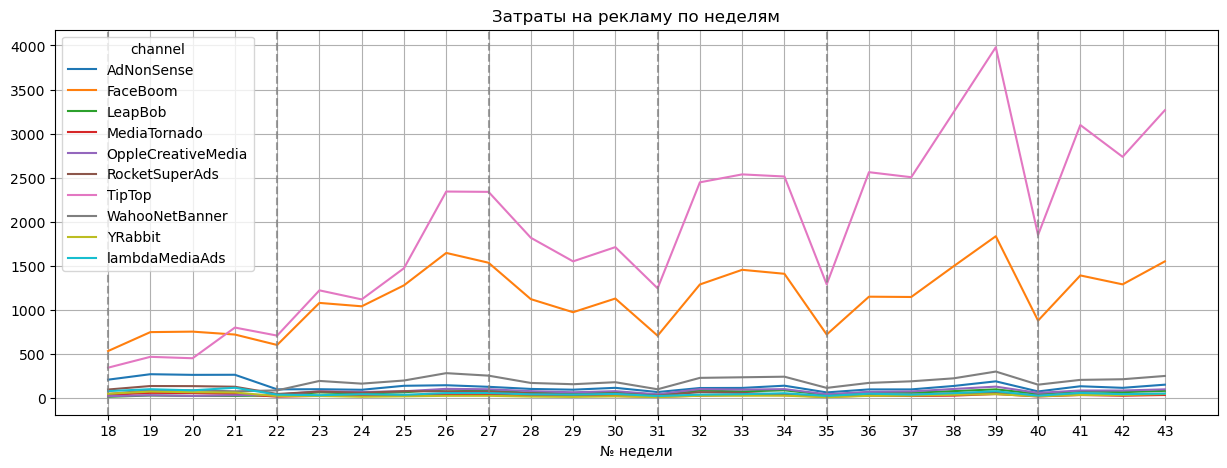

In [51]:
# выведем график затрат на рекламу по неделям с разбивкой по рекламным каналам 
market_channel_dur.pivot_table(
            index='channel', columns='week', values='costs'
                            ).T.plot(
    grid=True,  # добавляем сетку
    xticks=sorted(marketing.week.unique()),  # отметки на оси X — названия колонок
    figsize=(15, 5)  # размер графика
        )

# добавим линии разделяющие месяца
next_month_array = marketing[
    marketing.month != (marketing.month.shift(1))]['week'].unique()
                        # определяем недели где произошло изменение месяца
for line_x in next_month_array:
    plt.axvline(x=line_x, color='gray', linestyle='--', alpha=0.75, label='месяц')

plt.xlabel('№ недели')  # название оси X
plt.title('Затраты на рекламу по неделям')  # название графика
plt.show()

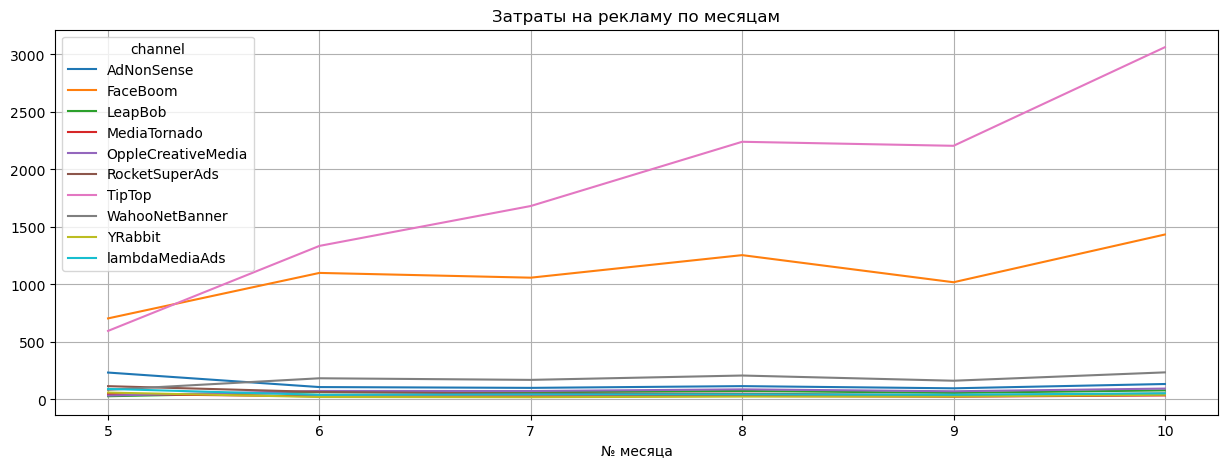

In [52]:
# выведем график затрат на рекламу по месяцам с разбивкой по рекламным каналам 
market_channel_dur.pivot_table(
            index='channel', columns='month', values='costs'
                            ).T.plot(
    grid=True,  # добавляем сетку
    xticks=sorted(marketing.month.unique()),  # отметки на оси X — названия колонок
    figsize=(15, 5)  # размер графика
        )

plt.xlabel('№ месяца')  # название оси X
plt.title('Затраты на рекламу по месяцам')  # название графика
plt.show()

**Промежуточный вывод по расходам на рекламу по времени**: <br>
- По затраченным средствам есть два явных лидера - TipTop и FaceBoom. Остальные источники имеют скромные бюджеты и их роль в рекламном бюджете минимальна.
- TipTop увеличивает затраты с течением времени, но с большими колебаниями по неделям. FaceBoom удерживает затраты в диапазоне 500-1000 в месяц и калебания сдержаннее. 
- Прослеживается явная сезонность по бюджету рекламных компаний.

Т.к. о проводимых акциях/событиях с увеличением рекламного бюджета нам не сообщалось, будем исходить из того, что пики связаны с общем повышением привлечения пользователей.

#### Дополнительная проверка расчета общего CAC

Дополнительно произведем валидацию данные и рассчитаем САС по средней стоимости привлечения по когортам (по конкретным рекламным компания) из таблицы profiles.

In [53]:
# сформируем таблицу с расчетом САС по средней стоимости привлечения по рекламным компаниям
valid_cac = profiles[profiles.channel != 'organic'].groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(
                                'acquisition_cost', ascending=False).round(2).reset_index()
valid_cac = valid_cac.rename(columns={'acquisition_cost':'CAC_valid'}) # переименовываем столбец

# добавим столбец с САС из market_channel_sum для удобства сравнения
valid_cac = valid_cac.merge(market_channel_sum[['channel', 'CAC']], on='channel', how='left')

valid_cac

,channel,CAC_valid,CAC
0,TipTop,2.80,2.80
1,FaceBoom,1.11,1.11
2,AdNonSense,1.01,1.01
3,lambdaMediaAds,0.72,0.72
4,WahooNetBanner,0.60,0.60
5,RocketSuperAds,0.41,0.41
6,OppleCreativeMedia,0.25,0.25
7,YRabbit,0.22,0.22
8,MediaTornado,0.22,0.22
9,LeapBob,0.21,0.21


В таблице market_channel_sum САС рассчитан по суммарным данным за канал. <br>
В таблицу valid_cac САС рассчитан по средний стоимости привлечения пользователя по каждому рекламному дню. <br>
Данные по САС совпадают. Допускается небольшая неточность связанная с округлением при расчетах. 

#### Вывод по разделу

Общие маркетинговые показатели

    - Общий бюджет маркетинга составил - 105 497,43.
    - По абсолютному объему полученных средств лидером является TipTop (32% от всех пользователей).
    - По общей окупаемости канал FaceBoom (самый низкий результат в 79% окупаемости) и AdNonSense не окупаются. 
    - Самое дорогое привлечение пользователей по каналу TipTop (2,8 за пользователя).
    - Органические пользователи (37%) приносят 21% прибыли.
    
Анализ расходов на рекламу по неделям/месяцам

    - По затраченным средствам есть два явных лидера - TipTop и FaceBoom. Остальные источники имеют скромные бюджеты и их роль в рекламном бюджете минимальна.
    - TipTop увеличивает затраты с течением времени, но с большими колебаниями по неделям. FaceBoom удерживает затраты в диапазоне 500-1000 в месяц и калебания сдержаннее. 
    - Прослеживается явная сезонность по бюджету рекламных компаний.


### Оценка окупаемости рекламы

Органических пользователей исключим из выборки, чтобы они не оказывали влияния на оценки окупаемости рекламы. <br> 
Для оценки общих тенденций и бизнес показателей - органических пользователей лучше учитывать т.к. реклама позволяет косвенно привлекать новых пользователей. 

In [54]:
# выставим даты
min_date = datetime(2019, 5, 1)
max_date = datetime(2019, 10, 27)
days_num = (max_date - min_date).days
now_day = datetime(2019, 11, 1)
horizon_days = 14

# исключаем необходимые данные из выборки
profiles_mark_metric = profiles.drop(columns=['revenue']).query('channel != "organic"')

#### Общая окупаемость рекламы

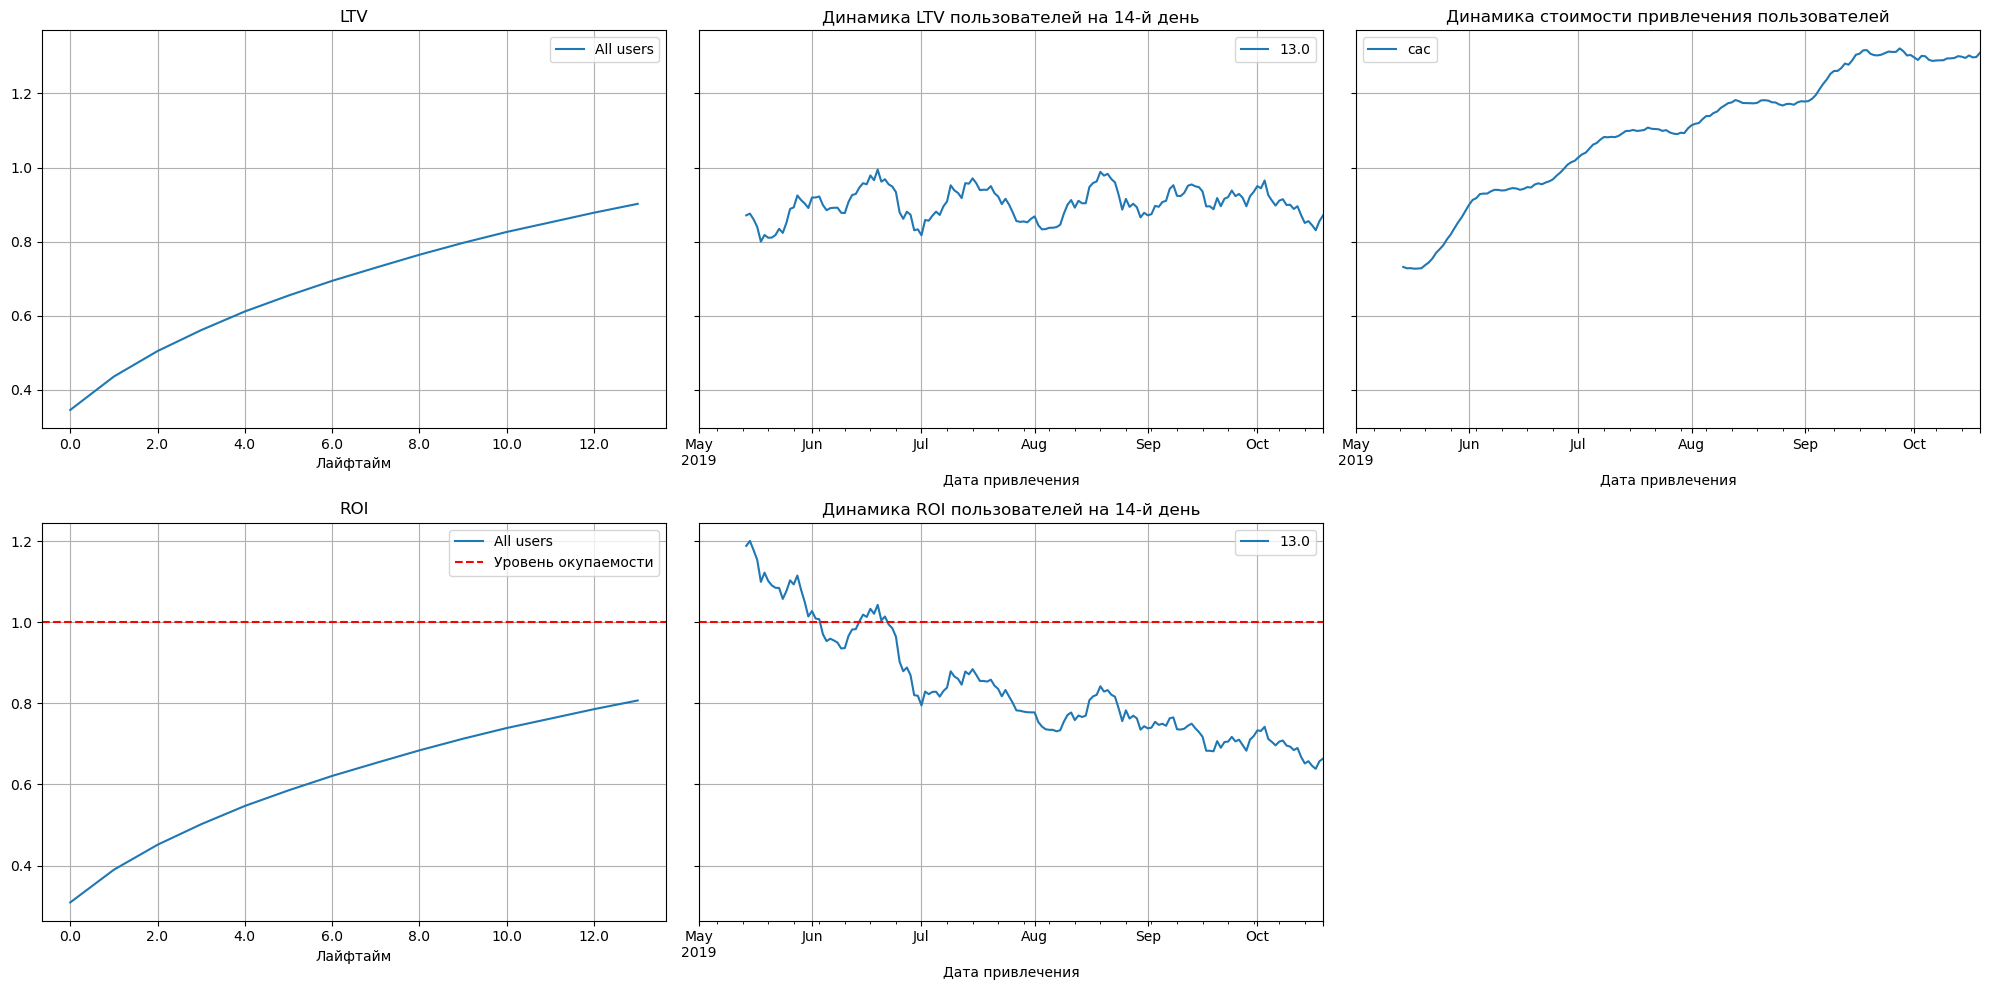

In [55]:
# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_mark_metric,
    orders,
    now_day, 
    horizon_days
    )

# строим общие графики LTV/ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 
        window=14)

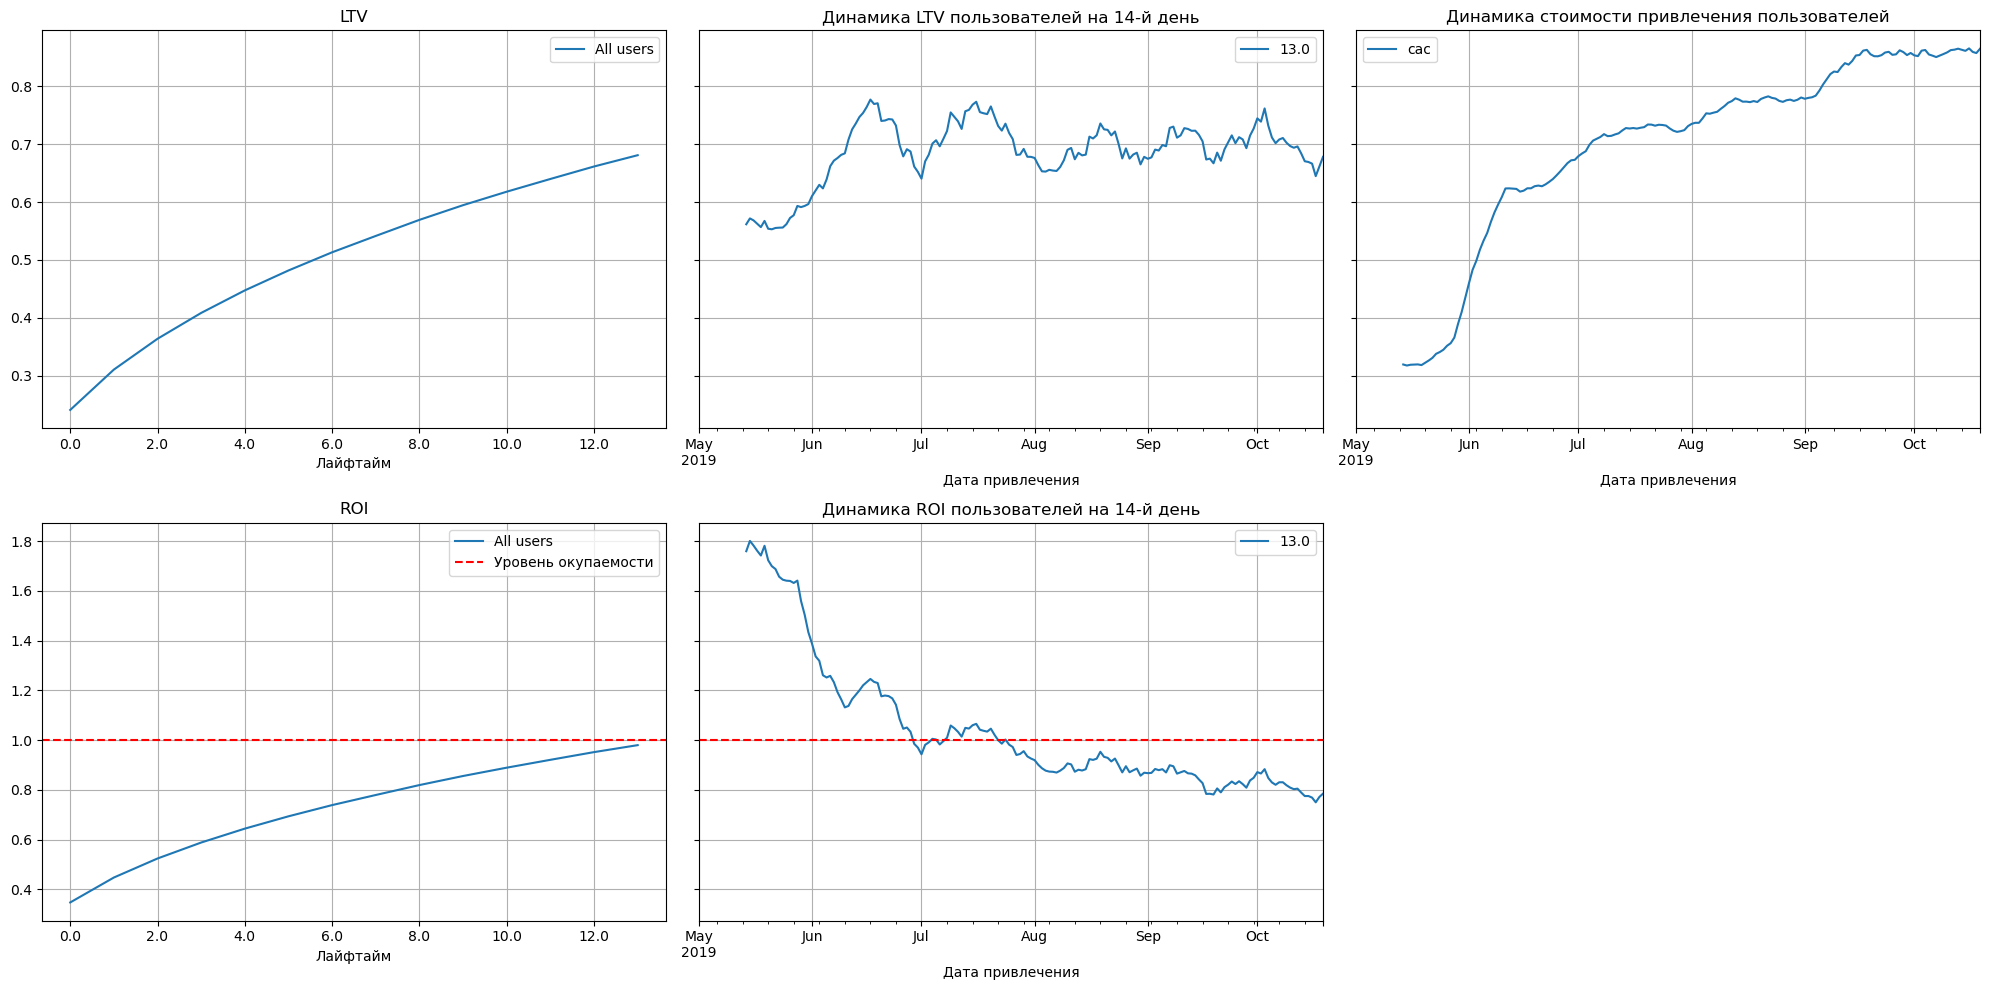

In [56]:
# проверим ROI с учетом органических пользователей
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.drop(columns=['revenue']),
    orders,
    now_day, 
    horizon_days
    )

# строим общие графики LTV/ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 
        window=14)

**Промежуточный вывод по общим данным окупаемости рекламы**: 
- Затраты на рекламу не окупаются. ROI чуть выше 80% под конец 13 недели.
- LTV имеет небольшую сезонность, но колебания держатся в пределах 0,8..1,0.
- Стоимость привлечения новых клиентов постепенно увеличивается, а окупаемость падает. Для первых когорт (минимальная САС) ROI был положительным. Для пользователей, привлеченных в середине июля, ROI стал отрицательным (меньше 100%).
- С учетом органических пользователей окупаемость ROI ~98%. Но динамика сохраняется.

#### Анализ конверсии и удержания пользователей

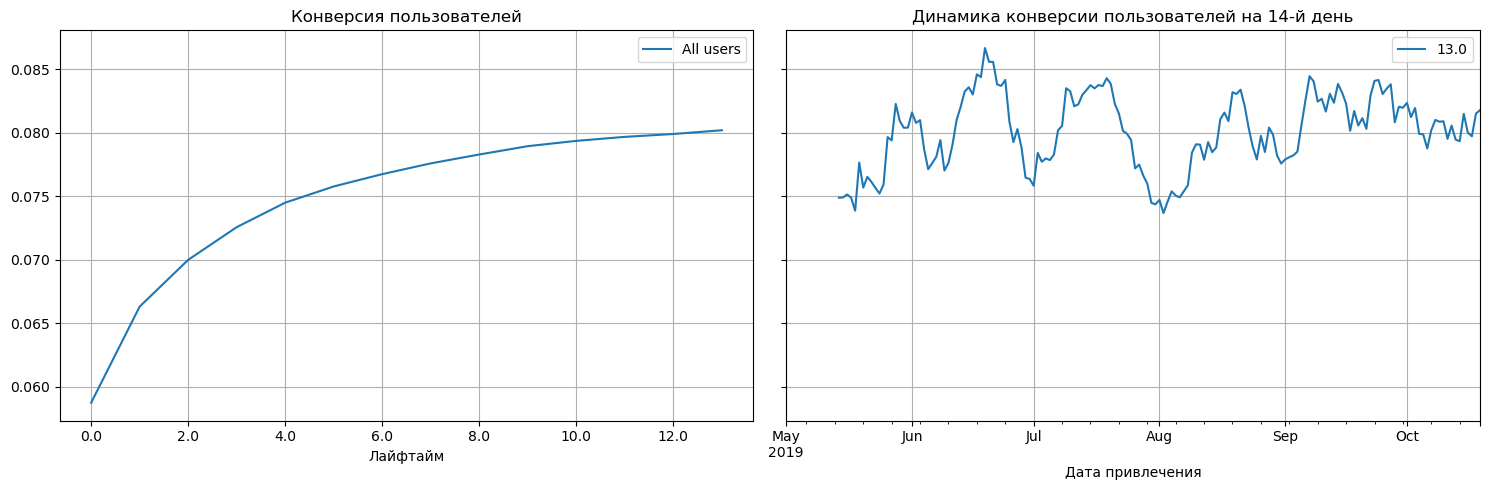

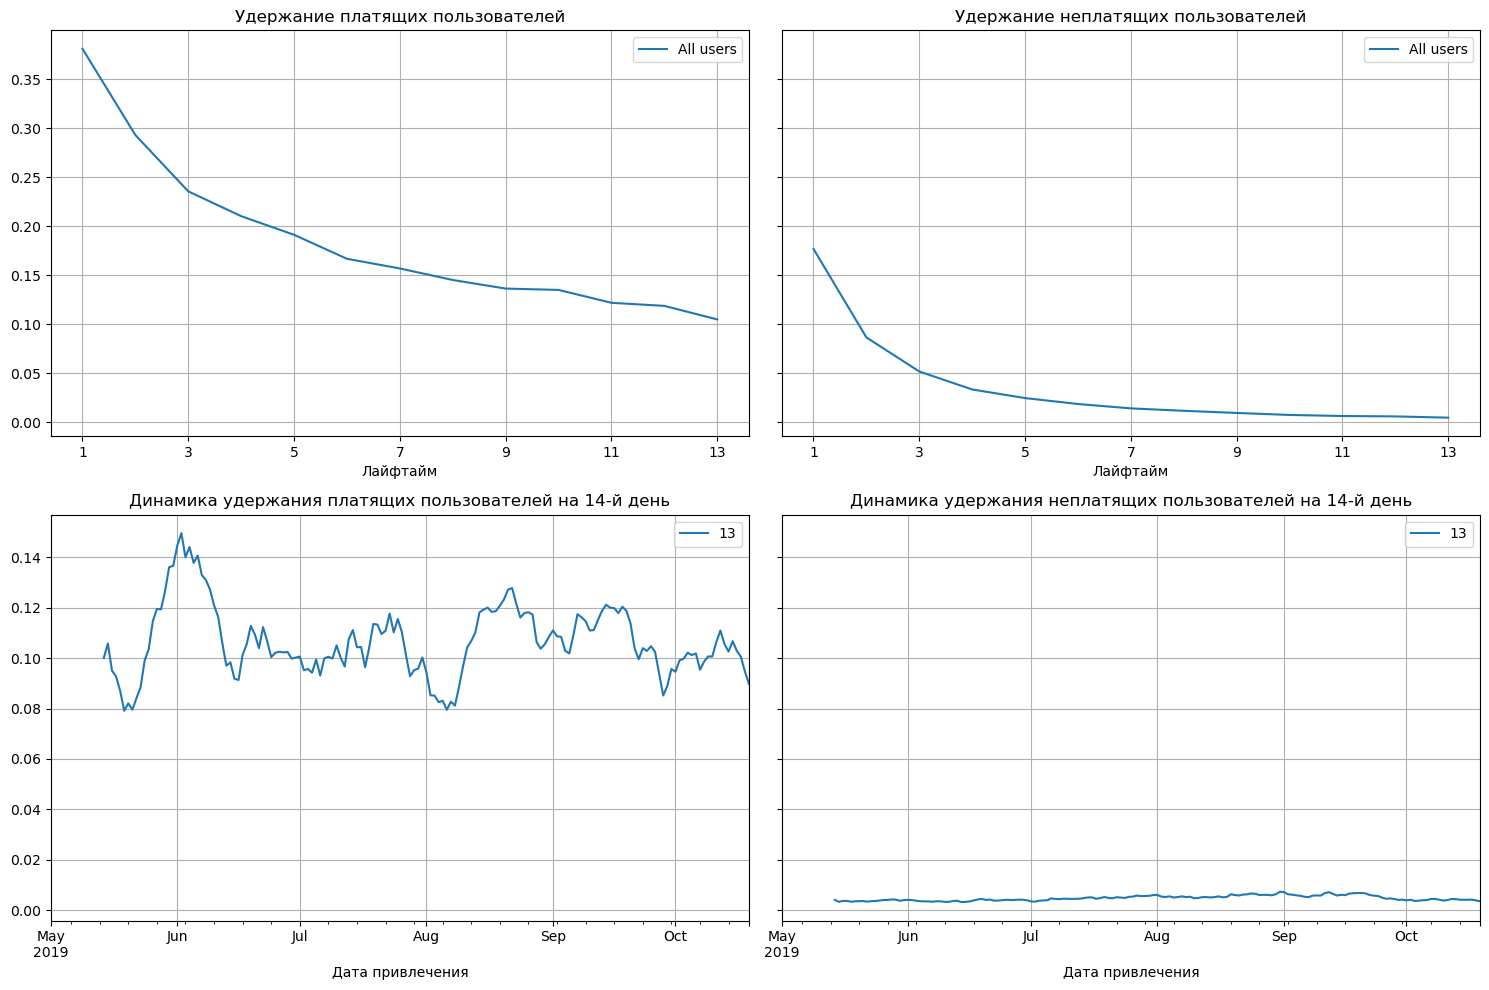

In [57]:
# общие данные
# получаем данные конверсии
conversion_raw, conversion, conversion_history = get_conversion( 
        profiles_mark_metric,
        orders,
        now_day,
        horizon_days )

# получаем данные удержания
retention_raw, retention, retention_history = get_retention(
        profiles_mark_metric, 
        visits, 
        now_day, 
        horizon_days )

# строим графики конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=14)

# строим графики удержания
plot_retention(retention, retention_history, horizon_days, window=14)

- Есть небольшая сезонность в удержании пользователей по когортам. <br>
- Стабильно низкое удержание для не платящих пользователей. 

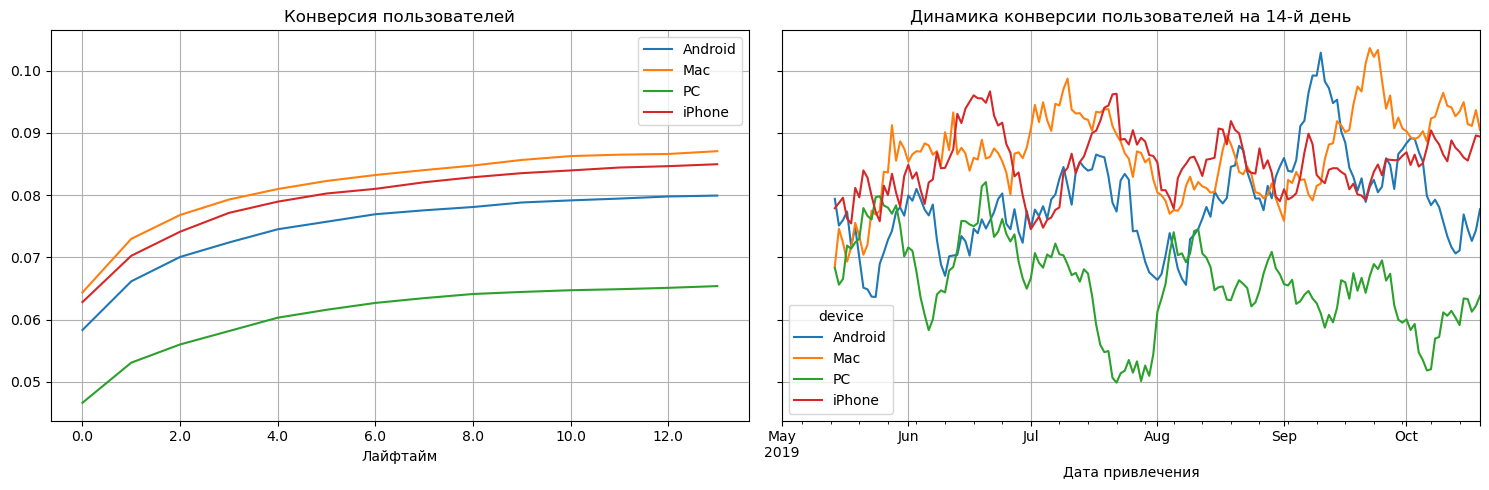

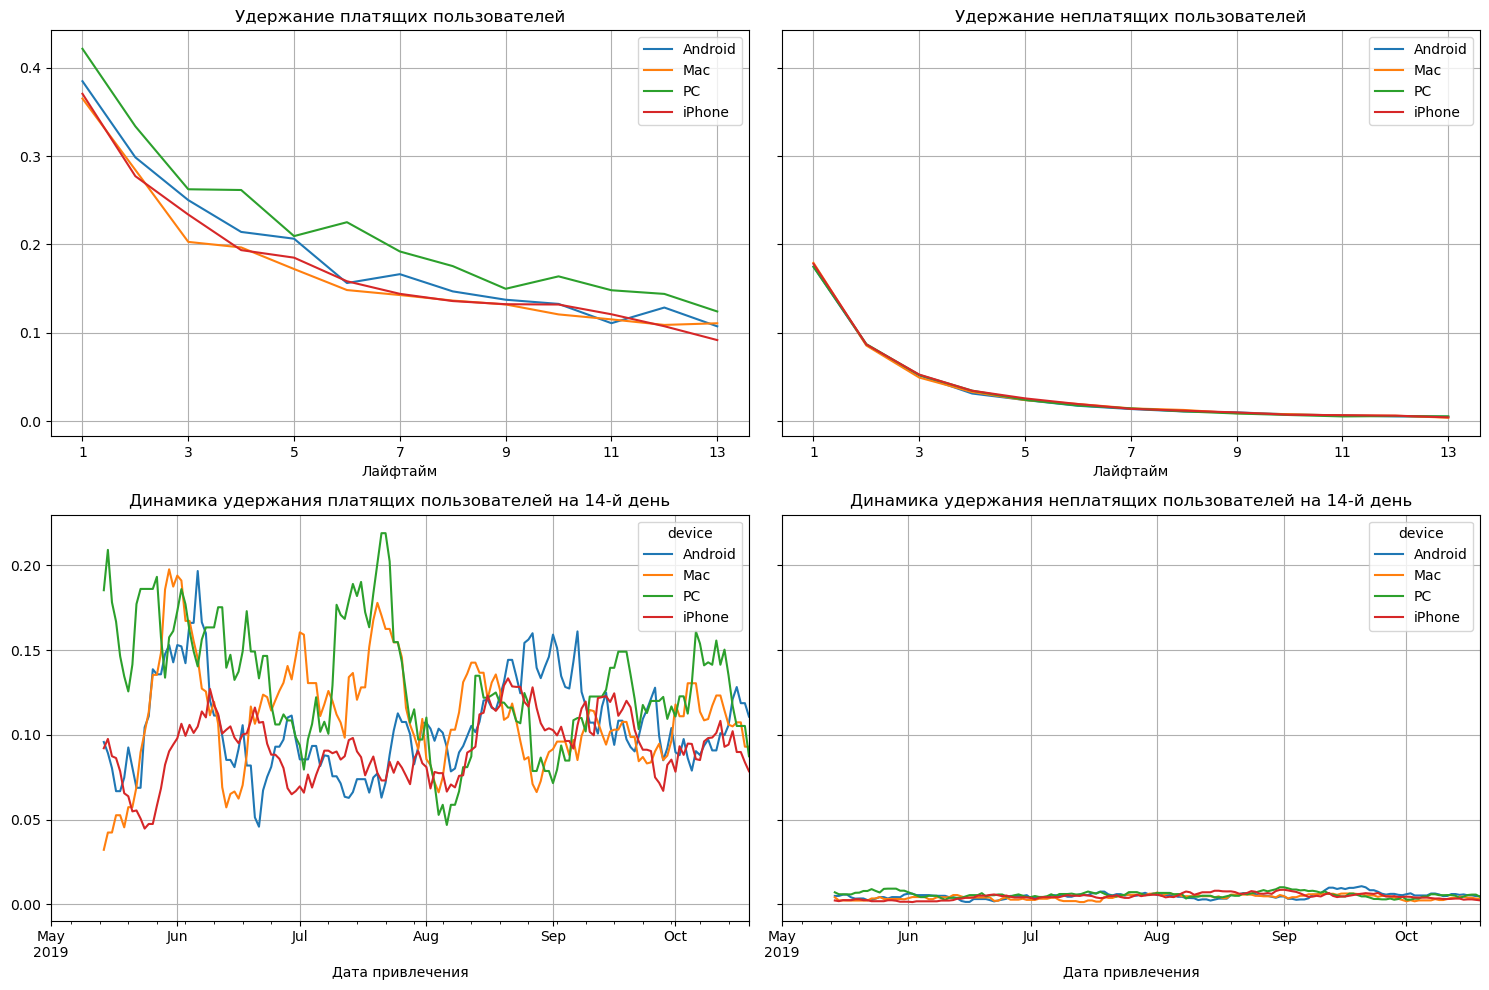

In [58]:
# данные с разбивкой по устройствам
dimensions=['device']

# получаем данные конверсии
conversion_raw, conversion, conversion_history = get_conversion( 
        profiles_mark_metric,
        orders,
        now_day,
        horizon_days,
        dimensions=dimensions )

# получаем данные удержания
retention_raw, retention, retention_history = get_retention(
        profiles_mark_metric, 
        visits, 
        now_day, 
        horizon_days,
        dimensions=dimensions )

# строим графики конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=14)

# строим графики удержания
plot_retention(retention, retention_history, horizon_days, window=14)

- Низкая конверсия пользователей PC. Есть 'падения' для когорт с середины июля по август и в первой половине октября.
- Удержание пользователей равномерно распределено вне зависимости от устройства.
- Удержание платящих пользователей на PC чуть выше  остальных устройств


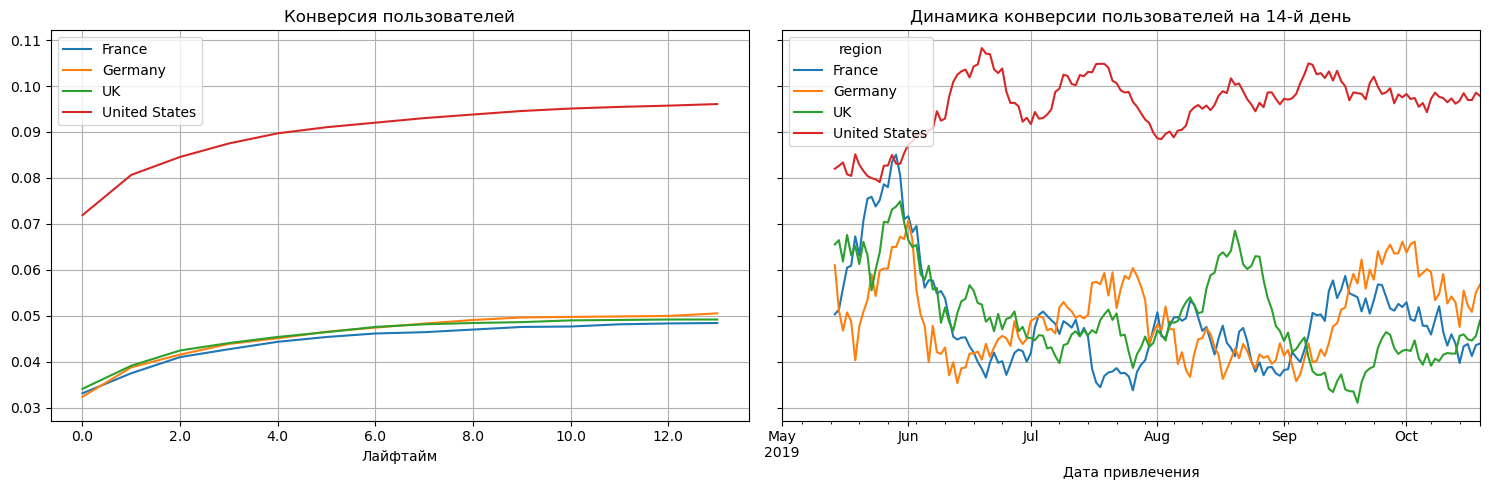

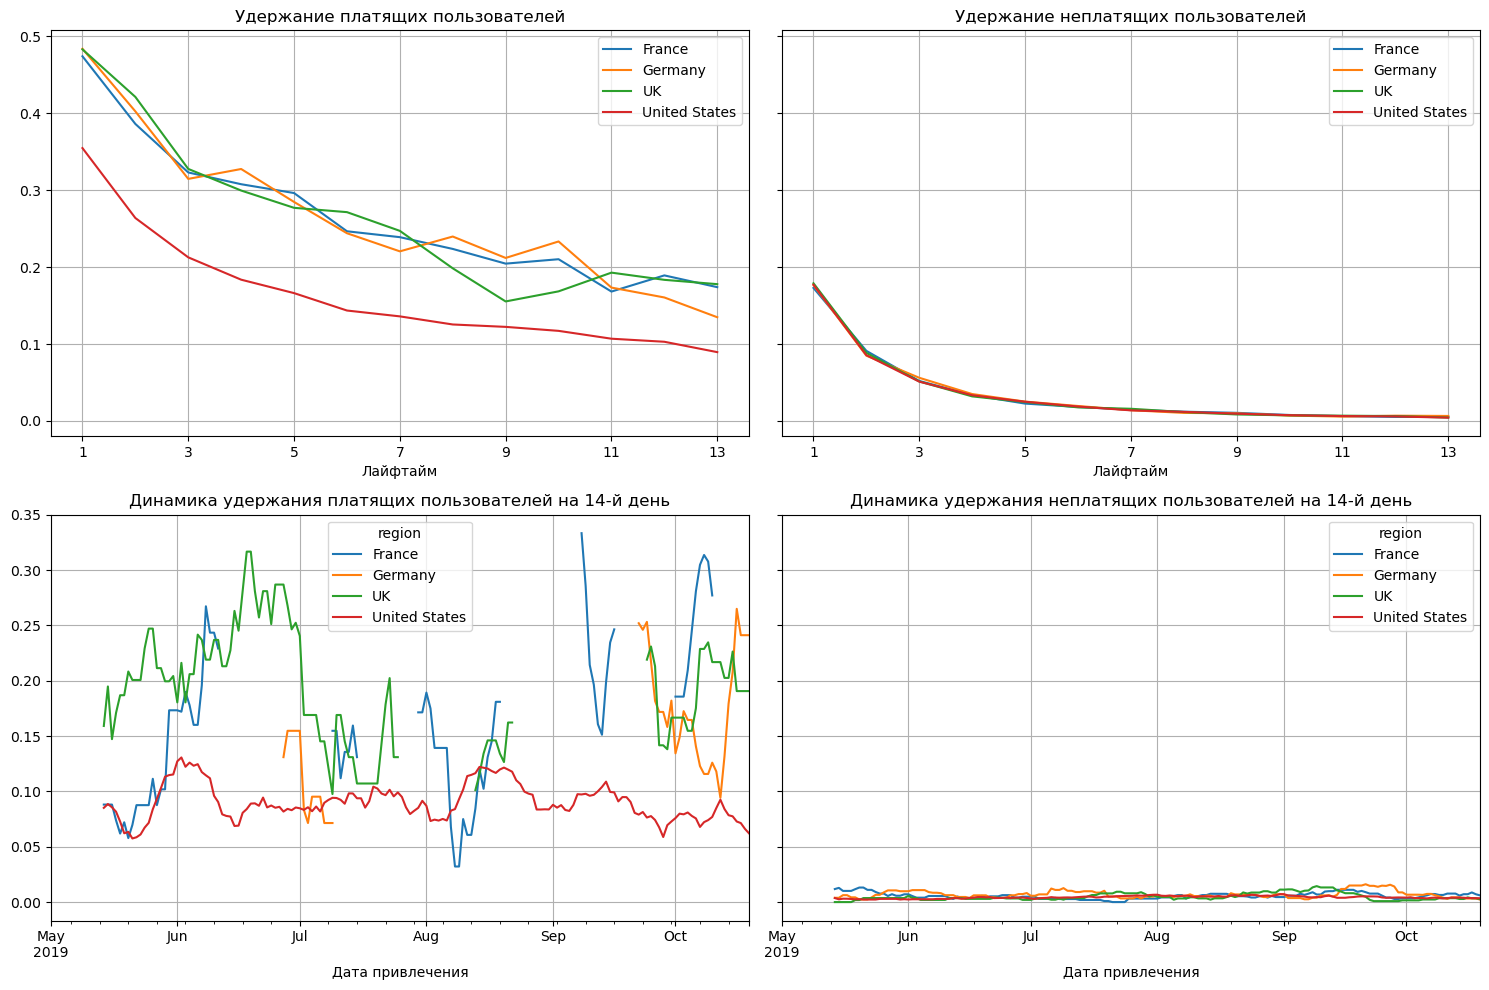

In [59]:
# данные с разбивкой по странам
dimensions=['region']

# получаем данные конверсии
conversion_raw, conversion, conversion_history = get_conversion( 
        profiles_mark_metric,
        orders,
        now_day,
        horizon_days,
        dimensions=dimensions )

# получаем данные удержания
retention_raw, retention, retention_history = get_retention(
        profiles_mark_metric, 
        visits, 
        now_day, 
        horizon_days,
        dimensions=dimensions )

# строим графики конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=14)

# строим графики удержания
plot_retention(retention, retention_history, horizon_days, window=14)

- Большая конверсия пользователей из USA относительно других стран.
- Когорты с середины мая по июнь показывали высокую конверсию.
- Удержание платящих пользователей из USA низкое (менее 10% под конец 13 недели).


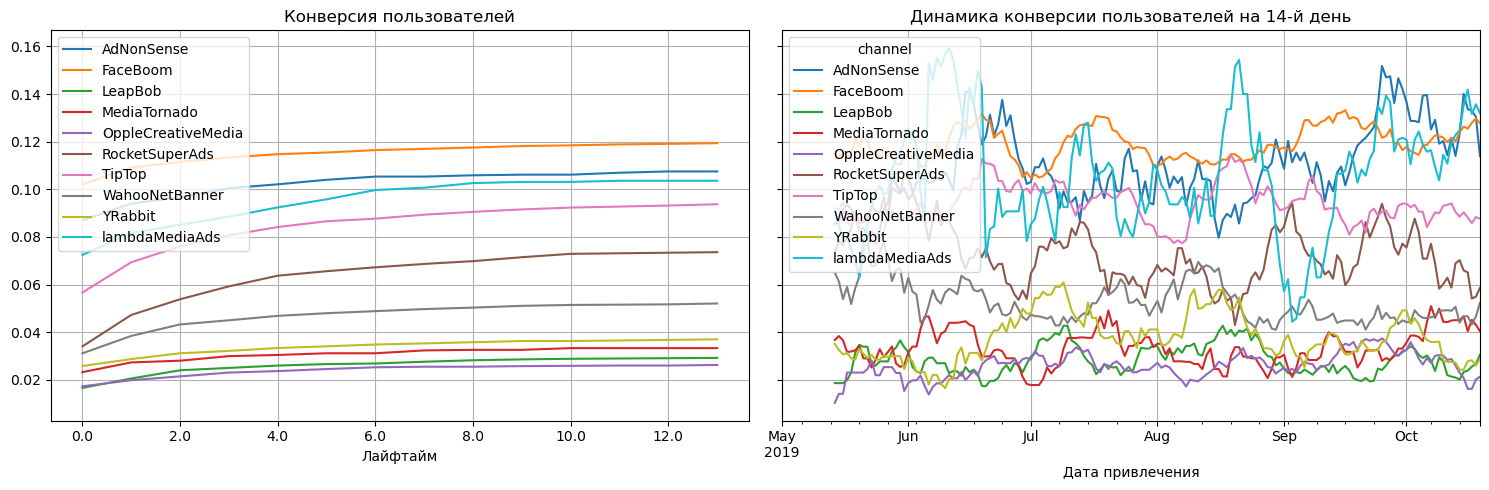

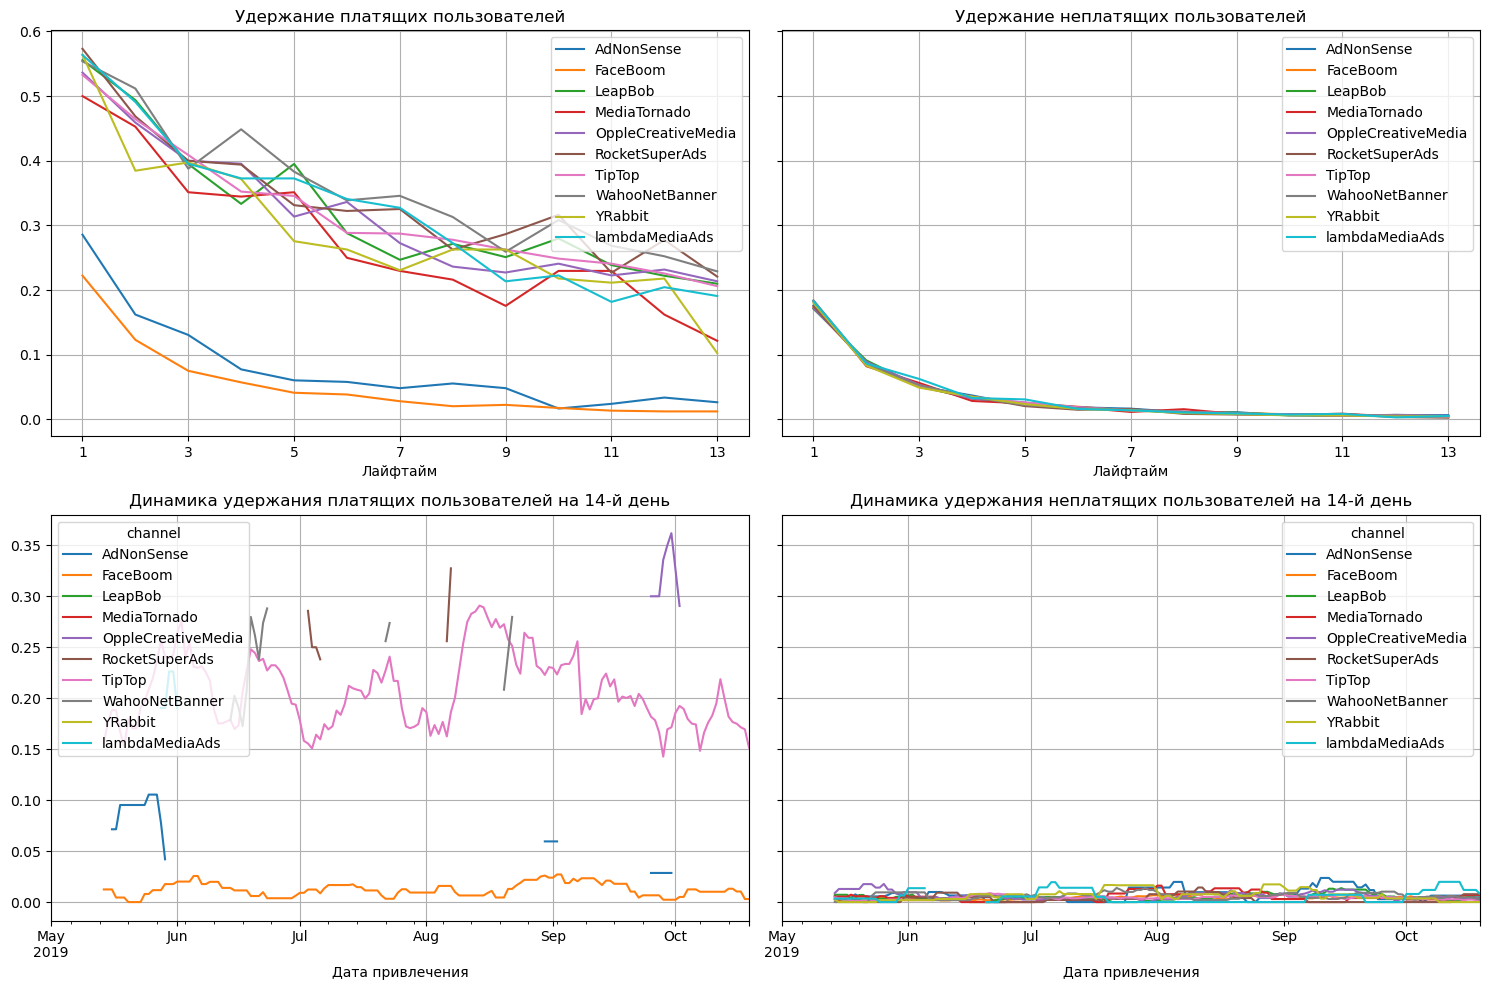

In [60]:
# данные с разбивкой по каналам привлечения
dimensions=['channel']

# получаем данные конверсии
conversion_raw, conversion, conversion_history = get_conversion( 
        profiles_mark_metric,
        orders,
        now_day,
        horizon_days,
        dimensions=dimensions )

# получаем данные удержания
retention_raw, retention, retention_history = get_retention(
        profiles_mark_metric, 
        visits, 
        now_day, 
        horizon_days,
        dimensions=dimensions )

# строим графики конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=14)

# строим графики удержания
plot_retention(retention, retention_history, horizon_days, window=14)

- Низкая конверсия (менее 5%) по каналам YRabbit, MedianTornado, LeapBob, OppleCreativeMedian.
- Высокая конверсия (свыше 10%) по каналам FaceBoom, AdNonSense, lambdaMedianAds.
- Конверсия по каналу lambdaMedianAds не равномерно по когортам.
- **Очень низкое удержание** по каналам FaceBoom, AdNonSense.
- В определенные периоды нет платящих когорт по большинству каналов привлечения. Дополнительно построим доп. графики с меньшим скользящим средним.

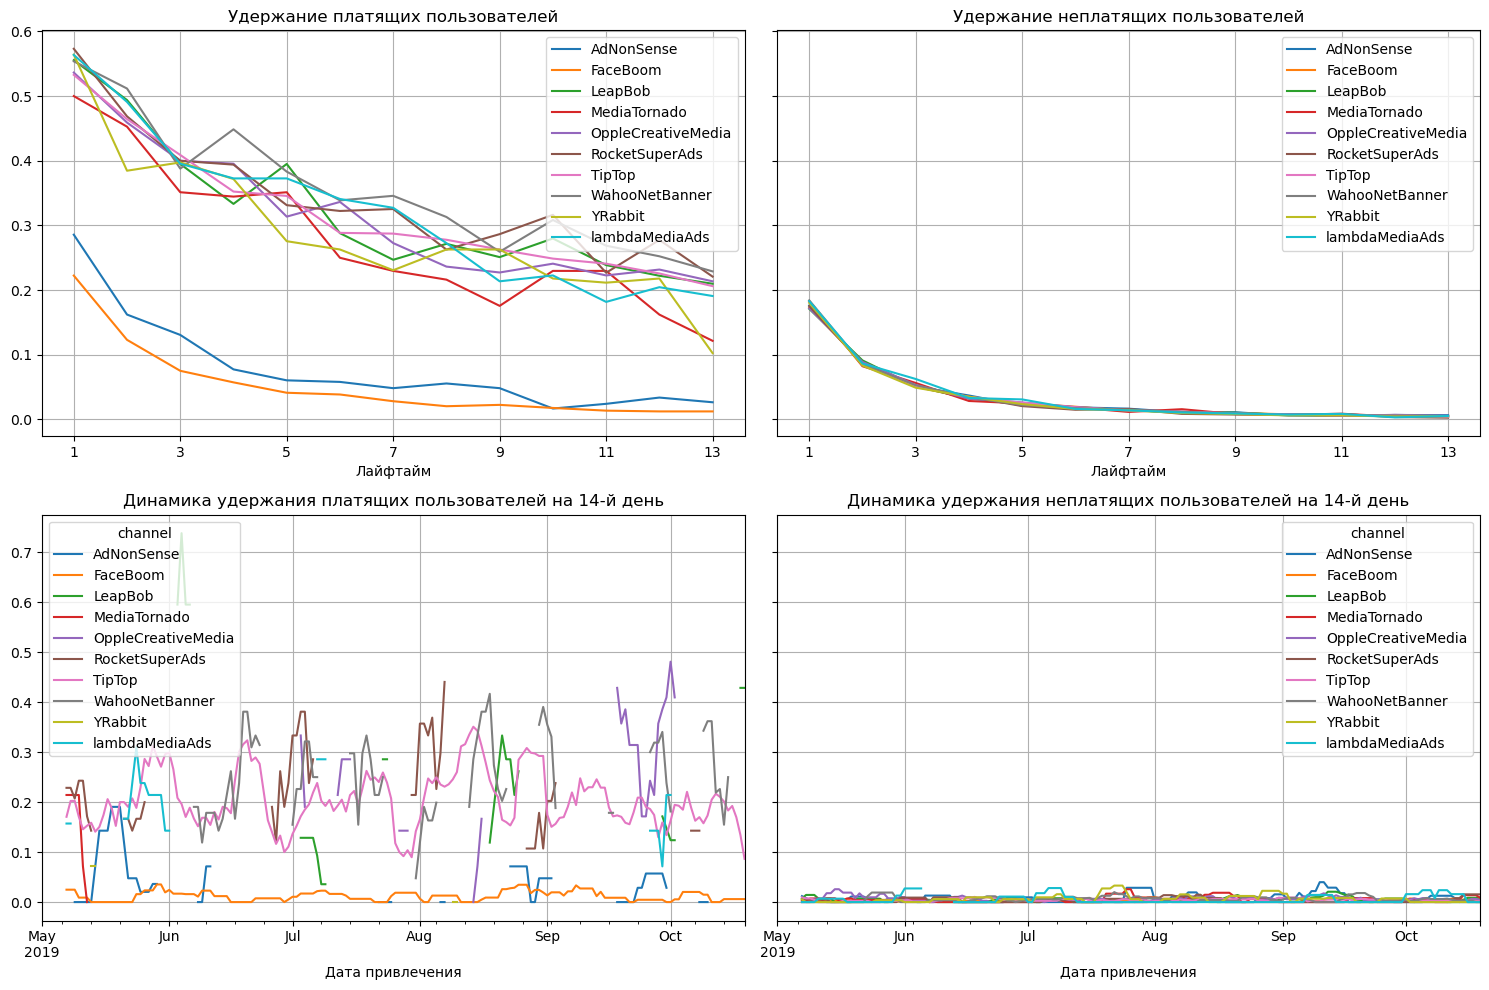

In [61]:
# построим графики удержания со скользящим средним в 7 дней
plot_retention(retention, retention_history, horizon_days, window=7)

Не равномерность ожидаемо выросла, но многих когорт все равно не хватает. Такое объясняется малым привлечением пользователей по этим каналам.

**Промежуточный вывод по анализу конверсии и удержанию по категориям**:
- Есть небольшая сезонность в удержании пользователей по когортам.
- Стабильно низкое удержание для не платящих пользователей.
- Низкая конверсия пользователей PC.
- Удержание платящих пользователей на PC чуть выше остальных устройств.
- Большая конверсия пользователей из USA относительно других стран.
- Когорты с середины мая по июнь показывали высокую конверсию.
- Удержание платящих пользователей из USA низкое (менее 10% под конец 13 недели).
- Низкая конверсия (менее 5%) по каналам YRabbit, MedianTornado, LeapBob, OppleCreativeMedian.
- Высокая конверсия (свыше 10%) по каналам FaceBoom, AdNonSense, lambdaMedianAds.
- Конверсия по каналу lambdaMedianAds не равномерно по когортам.
- **Очень низкое удержание** по каналам FaceBoom, AdNonSense.
- В определенные периоды нет платящих когорт из за малого количества привлечения пользователей.

##### Проверка гипотезы распределение рекламных каналов по странам

Появилась гипотеза что пользователи привлеченные по каналу FaceBOOM из USA. Проверим ее.

In [62]:
# создаем смежную таблицу
df_chan_reg = profiles.pivot_table(index='channel', values='user_id',
                        columns='region', aggfunc=['count'],
                                  margins=True).droplevel(0, axis=1)

# Создаем таблицу с вычисление процентов от общего по каналу привлечения
df_percent = (df_chan_reg.div(df_chan_reg['All'], axis=0)*100).round(2)
df_percent = df_percent.drop(columns=['All'])  # убираем процентный столбец "All" (не нужен)
df_percent = df_percent.add_suffix('_%') # переименуем столбцы с процентами

# Создаем список столбцов сначало абсолюютное значение, потом относительное
columns_list = []
for col in df_chan_reg.columns:
    columns_list.append(col)  # Абсолютное значение
    if col != 'All':  # Для итогового столбца "All" проценты не нужны
        columns_list.append(col + '_%')  # Процентное значение
        
# Объединяем таблицы с правильным расположением столбцов
df_chan_reg = pd.concat([df_chan_reg, df_percent], axis=1)[columns_list]

df_chan_reg

region,France,France_%,Germany,Germany_%,UK,UK_%,United States,United States_%,All
channel,,,,,,,,,
AdNonSense,1366.0,35.21,1219.0,31.42,1295.0,33.38,NaN,NaN,3880
FaceBoom,NaN,NaN,NaN,NaN,NaN,NaN,29144.0,100.00,29144
LeapBob,2988.0,34.94,2519.0,29.45,3046.0,35.61,NaN,NaN,8553
MediaTornado,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,100.00,4364
OppleCreativeMedia,2991.0,34.76,2562.0,29.77,3052.0,35.47,NaN,NaN,8605
RocketSuperAds,NaN,NaN,NaN,NaN,NaN,NaN,4448.0,100.00,4448
TipTop,NaN,NaN,NaN,NaN,NaN,NaN,19561.0,100.00,19561
WahooNetBanner,2971.0,34.74,2579.0,30.15,3003.0,35.11,NaN,NaN,8553
YRabbit,NaN,NaN,NaN,NaN,NaN,NaN,4312.0,100.00,4312


Все рекламные каналы, которые работают на территории USA, работают только в одной стране. К ним относятся: FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit. Гипотеза подтвердилась.

#### Анализ окупаемости рекламы по устройствам

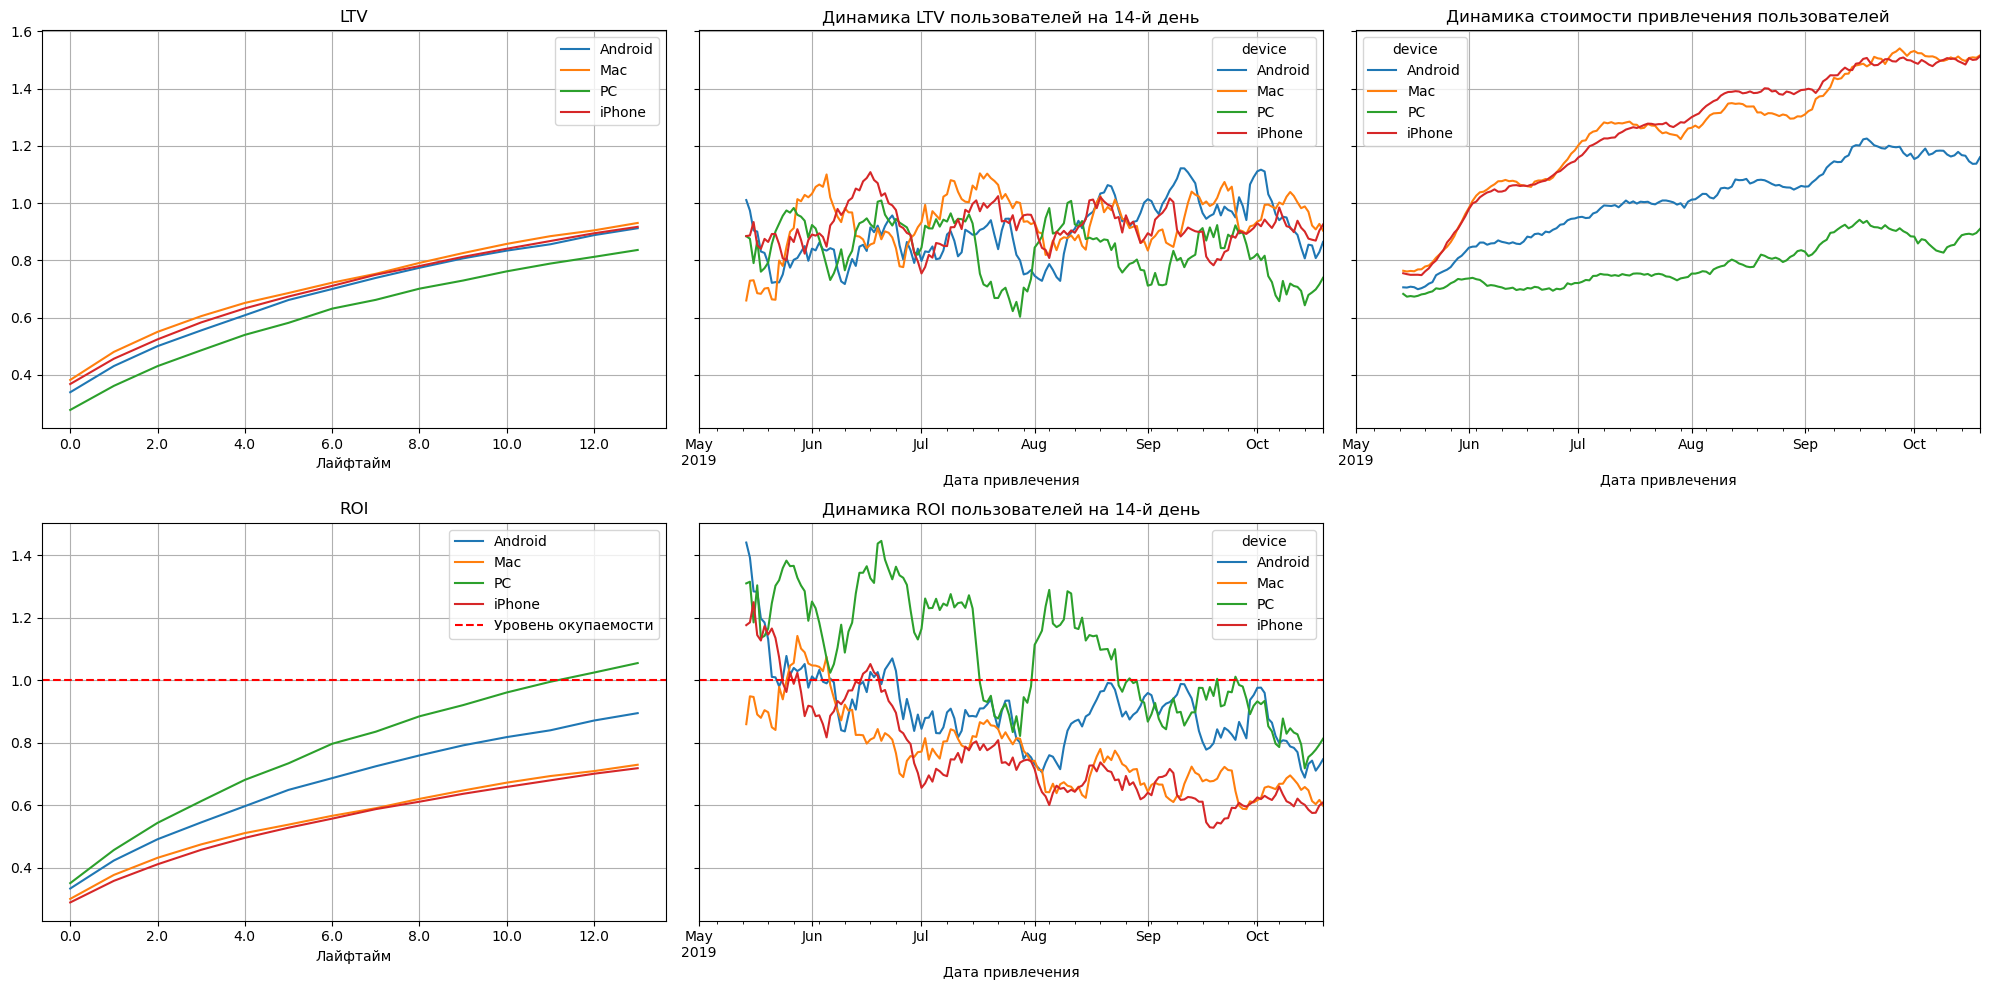

In [63]:
# данные с разбивкой по устройствам
dimensions=['device']

# получите данные LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_mark_metric,
    orders,
    now_day, 
    horizon_days,
    dimensions=dimensions 
    )

# строим общие графики LTV/ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 
        window=14)

**Промежуточный вывод по анализу окупаемости рекламы по устройствам**:
- Увеличение LTV равномерно.
- Наименьший LTV показывают пользователи на PC.
- CAC Увеличивается со временем для всех устройст. Самое маленькое увеличиение для PC. Самое большое увеличение для пользователей MAC и IPhone.
- Только пользователи PC окупают рекламу (\~110%). Самые низкие показатели окупаемости у пользователей MAC и IPhone (\~70%). Также по когортному анализу видно, что окупаемость рекламы падает с течением времени. Т.е. **есть обратная корреляция между стоимостью привлечения пользователей и окупаемостью рекламы.**


#### Анализ окупаемости рекламы по странам

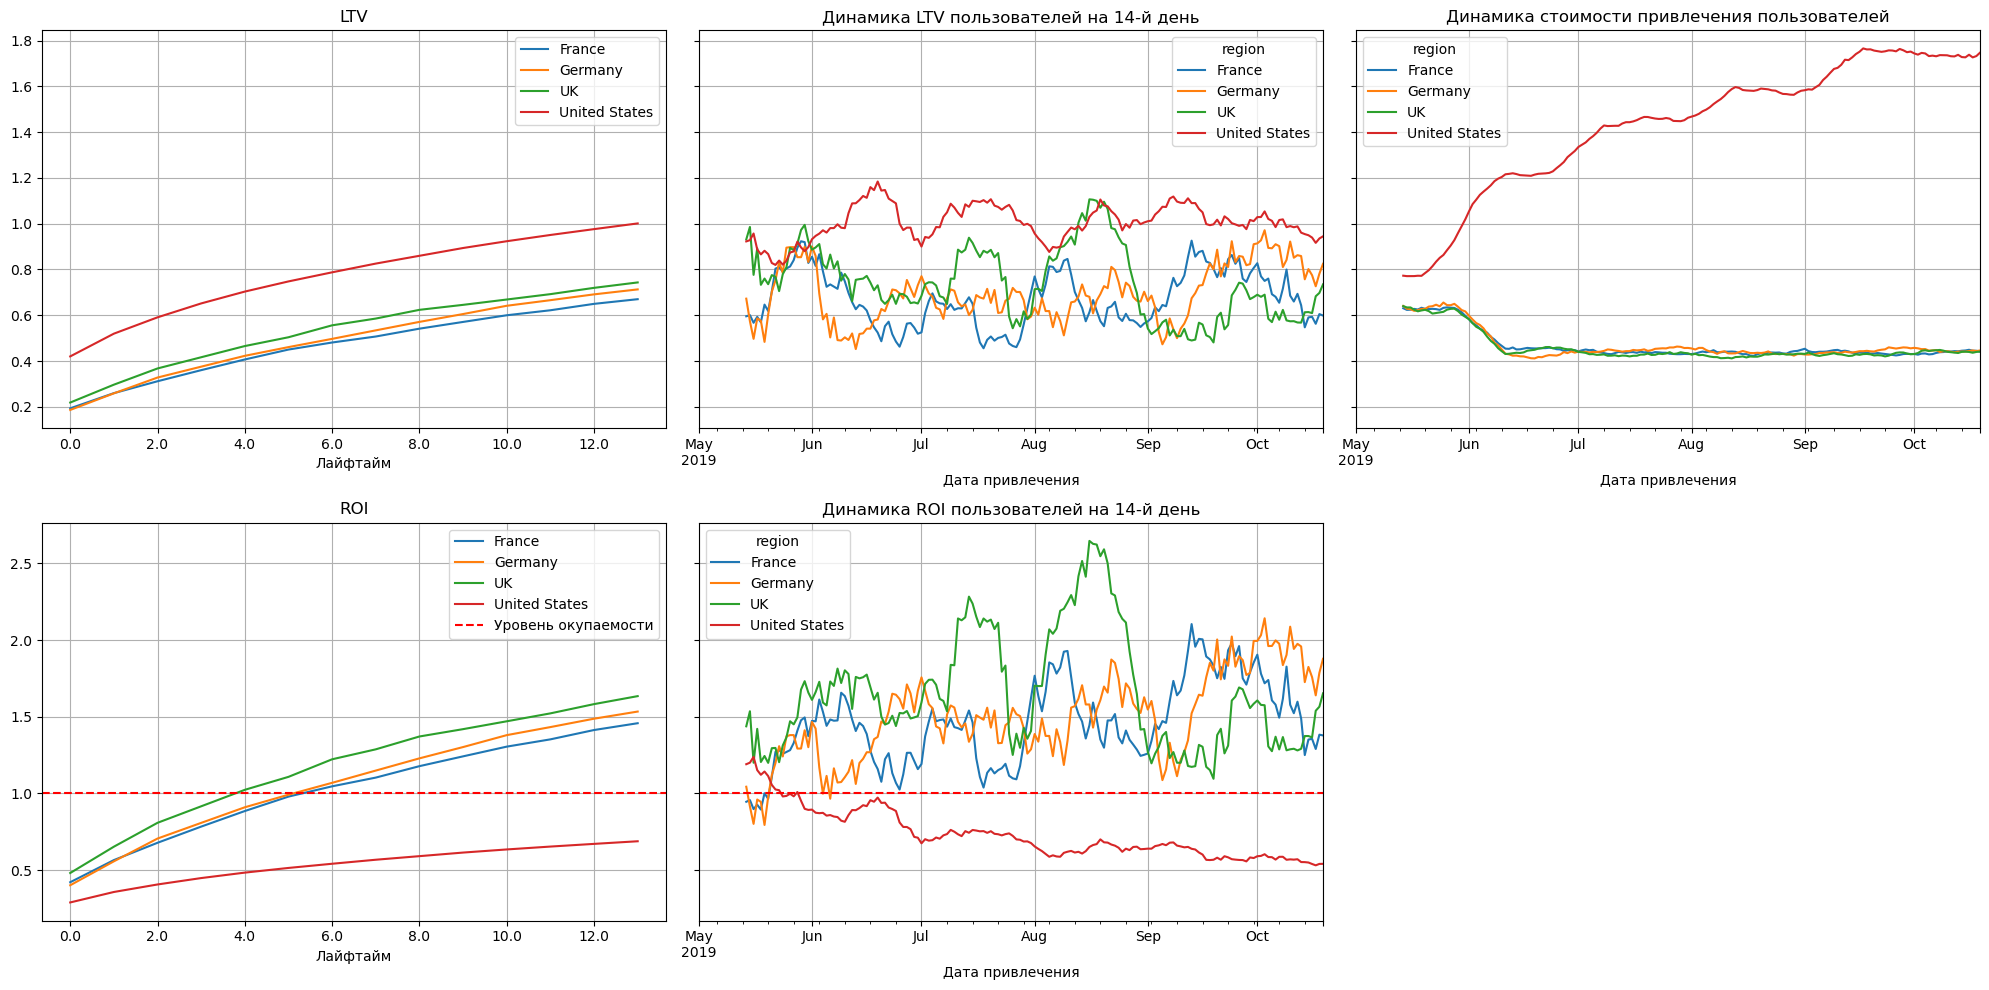

In [64]:
# данные с разбивкой по странам
dimensions=['region']

# получите данные LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_mark_metric,
    orders,
    now_day, 
    horizon_days,
    dimensions=dimensions 
    )

# строим общие графики LTV/ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 
        window=14)

**Промежуточный вывод по анализу окупаемости рекламы по странам**:
- Пользователи из USA платят заметно больше других пользователей.
- Не равномерное распределение LTV по когортам для всех пользователей кроме пользователей из USA.
- САС для пользователей USA очень сильно увеличивается с течением времени. Для всех остальных - уменьшилась в конце мая начале июня и держится на одном уровне.
- Из за очень высокой стоимости привлечения **пользователи из USA не окупаются.** Остальные пользователи окупаются. Опять видим прямую зависимость окупаемости от стоимости привлечения.

#### Анализ окупаемости рекламы по каналам привлечения

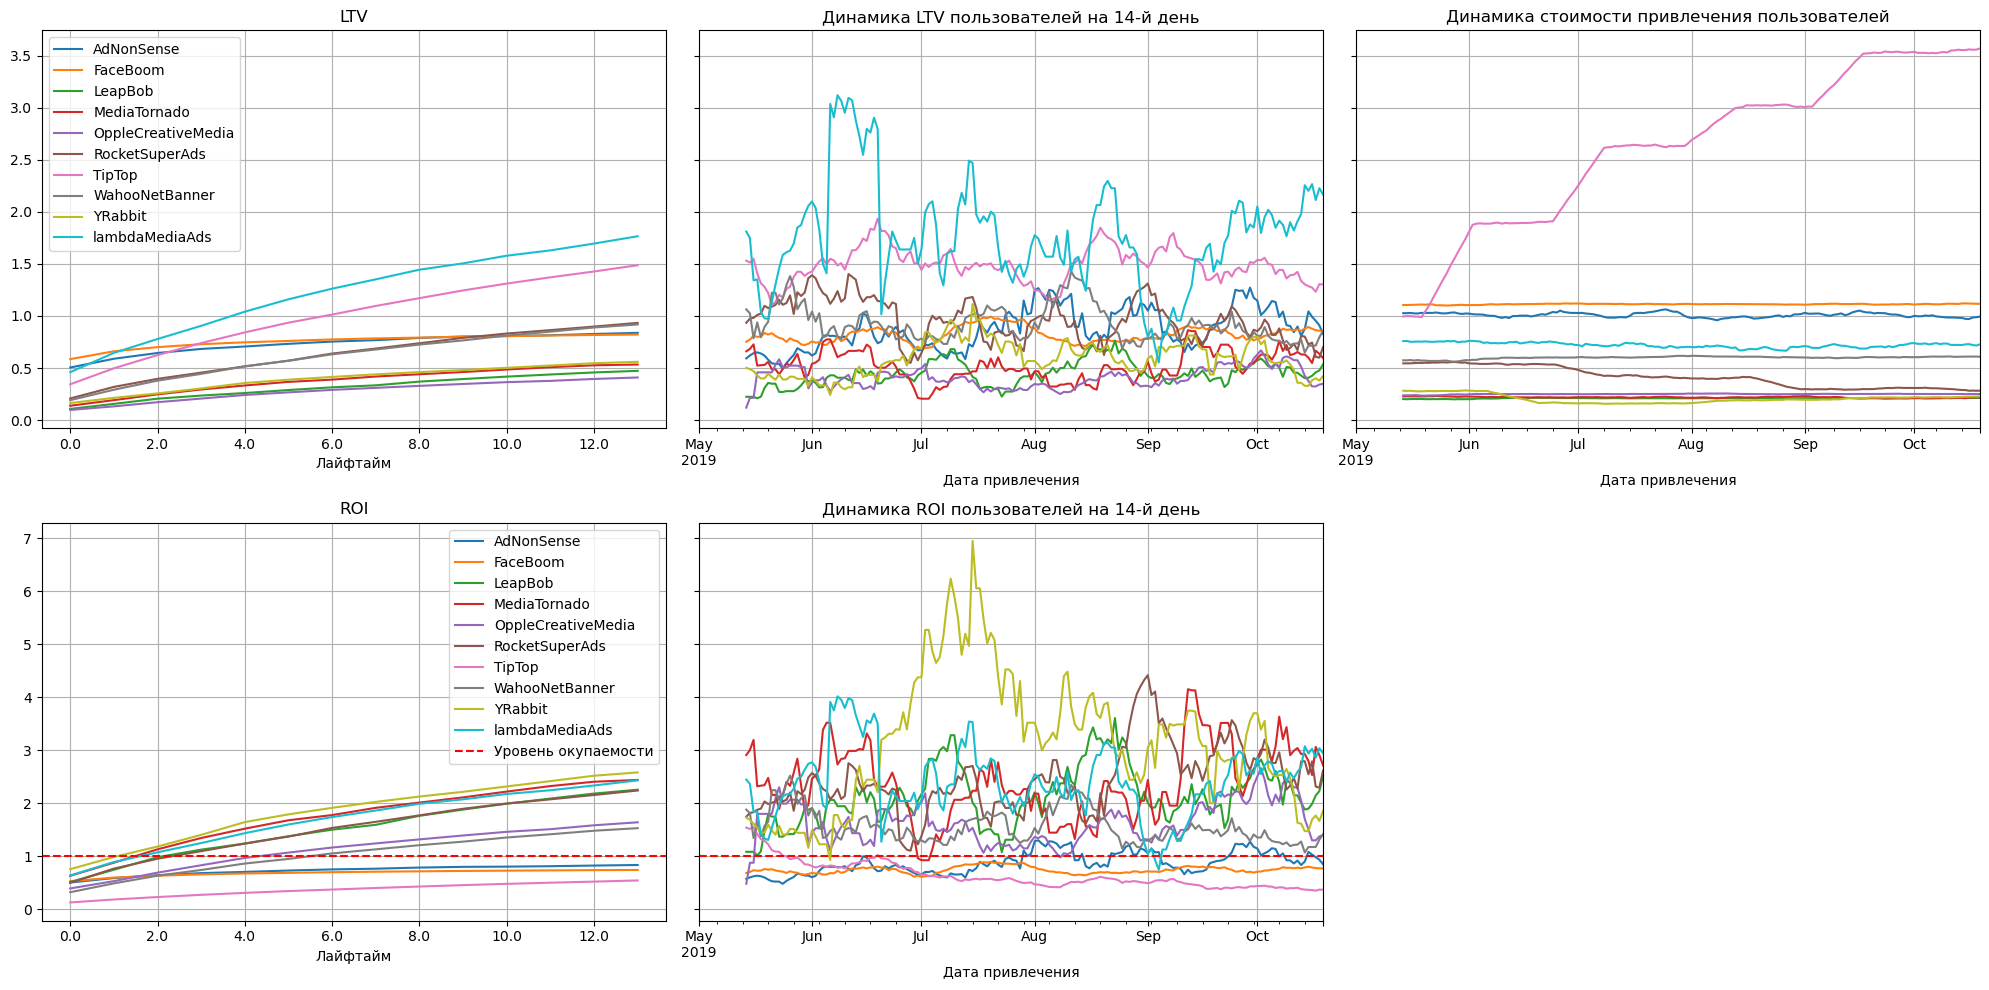

In [65]:
# данные с разбивкой по каналам привлечения
dimensions=['channel']

# получите данные LTV, CAC, ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_mark_metric,
    orders,
    now_day, 
    horizon_days,
    dimensions=dimensions 
    )

# строим общие графики LTV/ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 
        window=14, legends_second_vis=False) # отключаем доп. легенды для удобства чтения

Легенды одинаковые для всех графиков.

**Промежуточный вывод по анализу окупаемости рекламы по каналам привлечения**:
- Большой LTV показывают каналы lambdaMeduaAds и TipTop. 
- По каналу lambdaMeduaAds есть пик для когорты середины июня и просадка в начале сентября.
- **САС по каналу TipTop сильно увеличивается** с течением времени. По остальным каналам САС стабилен.
- Реклама не окупилась по каналам TipTop, FaceBoom, AdNonSense. По остальным каналам окупились.

#### Ответы на вопросы Заказчика

**Вопрос:** Окупается ли реклама, направленная на привлечение пользователей в целом? <br>
**Ответ:** <br> В целом реклама не окупается. Общий показатель ROI ~80%. 

**Вопрос:** Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы? <br>
**Ответ:** <br>
*По устройствам:* самые низкие показатели окупаемости у пользователей MAC и IPhone (ROI \~70%), также пользователи Android тоже не окупаются (ROI \~90%). <br>
*По странам:* не окупаются только пользователи из USA (ROI \~60%). <br>
*По рекламным каналам:* не окупается реклама по каналам TipTop (ROI \~60%), FaceBoom (ROI \~75%), AdNonSense (ROI \~80%).

**Вопрос:** Чем могут быть вызваны проблемы окупаемости? <br>
**Ответ:** <br> Основным негативным фактором является увеличение САС. Дополнительно есть узкое место в удержание платежеспособной аудитории: страна USA, каналы FaceBoom и TipTop (по ним самый большой траффик ~32.5% от всех пользователей (с учетом органических)). При этом по USA каналам MediaTornado, RocketSuperAds и YRabbit реклама окупилась. Следовательно, скорее всего, проблема не в регионе как таковом.

#### Вывод по разделу

Общая окупаемость рекламы

    - Затраты на рекламу не окупаются. ROI чуть выше 80% под конец 13 недели.
    - Стоимость привлечения новых клиентов постепенно увеличивается, а окупаемость падает. Для первых когорт (минимальная САС) ROI был положительным. Для пользователей, привлеченных в середине июля, ROI стал отрицательным (меньше 100%).
    - С учетом органических пользователей окупаемость ROI ~98%. Но динамика сохраняется.
    - FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit - каналы привлечения пользователей в USA. Другие каналы в USA не работают.
    
Анализ конверсии и удержания

    - Стабильно низкое удержание для не платящих пользователей.
    - Низкая конверсия пользователей PC.
    - Большая конверсия пользователей из USA относительно других стран. 
    - Когорты с середины мая по июнь показывали высокую конверсию.
    - Низкая конверсия (менее 5%) по каналам YRabbit, MedianTornado, LeapBob, OppleCreativeMedian.
    - Высокая конверсия (свыше 10%) по каналам FaceBoom, AdNonSense, lambdaMedianAds.
    - Конверсия по каналу lambdaMedianAds не равномерно по когортам.
    - Удержание платящих пользователей на PC чуть выше остальных устройств.
    - Удержание платящих пользователей из USA низкое (менее 10% под конец 13 недели). Это связано с основными каналами привлечения: FaceBoom и TipTop. 
    - Очень низкое удержание по каналам FaceBoom, AdNonSense.
    - В определенные периоды нет платящих когорт из за малого количества привлечения пользователей.

Окупаемость рекламы по устройствам пользователей

    - Увеличение LTV равномерно.
    - Наименьший LTV показывают пользователи на PC.
    - CAC увеличивается со временем для всех устройст. Самое маленькое увеличиение для PC. Самое большое увеличение для пользователей MAC и IPhone.
    - Только пользователи PC окупают рекламу (\~110%). Самые низкие показатели окупаемости у пользователей MAC и IPhone (\~70%). Также по когортному анализу видно, что окупаемость рекламы падает с течением времени. Т.е. есть обратная корреляция между стоимостью привлечения пользователей и окупаемостью рекламы.
    
Окупаемость рекламы по стране пользователей

    - Пользователи из USA платят заметно больше других пользователей.
    - Не равномерное распределение LTV по когортам для всех пользователей кроме пользователей из USA.
    - САС для пользователей USA очень сильно увеличивается с течением времени. Для всех остальных - уменьшилась в конце мая - начале июня и держится на одном уровне.
    - Из за очень высокой стоимости привлечения пользователи из USA не окупаются. Остальные пользователи окупаются. Опять видим прямую зависимость окупаемости от стоимости привлечения.
    
Окупаемость рекламы по каналу привлечения пользователей

    - Большой LTV показывают каналы lambdaMeduaAds и TipTop. 
    - По каналу lambdaMeduaAds есть пик для когорты середины июня и просадка в начале сентября.
    - САС по каналу TipTop сильно увеличивается с течением времени. По остальным каналам САС стабилен.
    - Реклама не окупилась по каналам TipTop, FaceBoom, AdNonSense. По остальным каналам окупились.
    
Промежуточные рекомендации отделу маркетинга

    - Обратить внимание на стоимость привлечения пользователей и возможность ее ограничивать.
    - Обратить внимание на настройку каналов FaceBOOM и TipTop т.к. их влияние основное.
    - Разработать стратегии для повышения удержания пользователей из USA.


### Общий вывод

**Предобработка данных:** <br>
- Переименованы столбцы
- Преобразованы типы данных
- Добавлены необходимые [столбцы](#Добавление-необходимых-столбцов)
- Проверены на наличие [дубликатов](#Проверка-дубликатов). [**Необходимо уточнить** список платных услуг и регламент работы с возвратом денежных средств](#график-платежей) 
- Пропусков в данных не обнаружено

**Общий анализ данных:** <br>
- Средний % платящих пользователей : 5,9 %
- Наибольшее расхождение в доле платящих пользователей наблюдается сначала по критерию рекламных источников, а затем по регионам.
- Основной рынок приложения — США, где сосредоточено 66,7 % всех пользователей. Кроме того, в США зафиксирован самый высокий процент платящих пользователей — 6,9 %.
- Наибольшая доля пользователей предпочитает iPhone — 36,3 % от общего числа. 
- Самые платёжеспособные пользователи используют Mac (6,4 %), за ними следуют владельцы iPhone (6,2 %). В то же время, наименьший процент платящих наблюдается среди пользователей ПК — 5,1%.
- Больше всего пользователей пришло органически (37,6 % от всех пользователей). На втором месте по рекламе FaceBoom (19,4 %), на третьем TipTop (13,0 %).
- [Каналы привлечения FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit работают только на рынке USA.](#Проверка-гипотезы-распределение-рекламных-каналов-по-странам)
- Больше среднего платящих пользователей привлекли каналы FaceBoom (12,2 %), AdNonSense (11,3 %), lambdaMediaAds (10,5 %), TipTop (9,6 %), RocketSuperAds (7,9 %). Остальные каналы привлекают заметно меньше платящих пользователей.
<br><br>

**Анализ маркетинговых показателей:**
- Общий бюджет маркетинга составил - 105 497,43.
- По абсолютному объему полученных средств лидером является TipTop.
- Самое дорогое привлечение пользователей по каналу TipTop (2,8 за пользователя).
- Органические пользователи (37%) приносят 21% прибыли.
- По затраченным средствам есть два явных лидера - TipTop и FaceBoom. Остальные источники имеют скромные бюджеты и их роль в рекламном бюджете минимальна.
- TipTop увеличивает затраты с течением времени, но с большими колебаниями по неделям. FaceBoom удерживает затраты в диапазоне 500-1000 в месяц и калебания сдержаннее.
<br><br>
    
**Оценка окупаемости рекламы:**
1. Затраты на рекламу и ROI:
    - Затраты на рекламу не окупаются: ROI к концу 13 недели ~80%, с учетом дохода от органических пользователей — ~98%.
    - Стоимость привлечения клиентов растет, а окупаемость снижается. Первые когорты с минимальным CAC показывали положительный ROI, но с середины июля он стал отрицательным (<100%).
    - По когортному анализу видно, что рост CAC обратным образом коррелирует с падением окупаемости рекламы.

2. Конверсия и удержание:
    - Низкая конверсия (<5%) на PC и по каналам YRabbit, MedianTornado, LeapBob, OppleCreativeMedian.
    - Высокая конверсия (>10%) у каналов FaceBoom, AdNonSense, lambdaMedianAds, хотя на lambdaMedianAds она неравномерна.
    - Низкое удержание у неплатящих пользователей и пользователей каналов FaceBoom, AdNonSense.
    - Удержание платящих на PC выше, чем на других устройствах, но у платящих из США оно низкое (<10% к 13-й неделе), что связано с каналами FaceBoom и TipTop.

3. Стоимость привлечения и окупаемость:
    - CAC растет на всех устройствах, минимальный рост у PC, максимальный — у Mac и iPhone.
    - Только пользователи PC окупают рекламу (\~110%). Самые низкие показатели окупаемости у Mac и iPhone (\~70%).
    - Пользователи из США платят больше других, но из-за высокой стоимости привлечения не окупаются. CAC для них продолжает расти, тогда как для остальных стабилизировался после мая-июня.

4. LTV и каналы привлечения:
    - Самый низкий LTV у пользователей PC, самый высокий — у каналов lambdaMedianAds и TipTop.
    - CAC на TipTop растет со временем, по остальным каналам стабилен.
    - Реклама не окупилась на TipTop, FaceBoom и AdNonSense, но окупилась на остальных каналах.

  

**Рекомендации на основе данных для отдела маркетинга:**
- Обратить внимание на стоимость  привлечения пользователей и возможность ее ограничивать.
- Обратить внимание на настройку каналов FaceBOOM и TipTop т.к. их влияние основное. Рассмотреть возможность увеличение трафик по другим каналам.
- Рекомендуется определить верхний предел CAC на основе данных. Предлагаемые значения: для пользователей PC — ~0,8, для Android — ~0,9, для iPhone/Mac — ~1,0. Также необходимо регулярно проводить корректировки в зависимости от изменения маркетинговых показателей.
- Разработать стратегии для повышения удержания пользователей из USA.
- Собрать/предоставить данные об эффективности рекламы. Основные данные: конверсии на разных этапах.
- Разработать стратегии для увеличения доли рынка или географии в странах, кроме USA.
- Рассмотреть возможность внедрения региональных цен и оценить их потенциальное влияние.
- Скорректировать региональную маркетинговую политику на основе региональных данных по используемым устройствам.
<br><br>
Необходимо сосредоточиться на диверсификации продукта по географии, каналам привлечения и устройствам, чтобы снизить риски и зависимость от отдельных факторов.